In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [2]:
mpl.rcParams['agg.path.chunksize'] = 10000

In [3]:
us_pollution_dataset = pd.read_csv('US_Pollution_2000_2023.csv')

In [4]:
us_pollution_dataset.head()

,Unnamed: 0,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,0,2000-01-01,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,1,2000-01-02,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2,2000-01-03,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,3,2000-01-04,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,4,2000-01-05,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58


In [5]:
us_pollution_dataset.columns

Index(['Unnamed: 0', 'Date', 'Address', 'State', 'County', 'City', 'O3 Mean',
       'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'CO Mean',
       'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'SO2 Mean',
       'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI'],
      dtype='object')

In [6]:
us_pollution_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665414 entries, 0 to 665413
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         665414 non-null  int64  
 1   Date               665414 non-null  object 
 2   Address            665414 non-null  object 
 3   State              665414 non-null  object 
 4   County             665414 non-null  object 
 5   City               665414 non-null  object 
 6   O3 Mean            665414 non-null  float64
 7   O3 1st Max Value   665414 non-null  float64
 8   O3 1st Max Hour    665414 non-null  int64  
 9   O3 AQI             665414 non-null  int64  
 10  CO Mean            665414 non-null  float64
 11  CO 1st Max Value   665414 non-null  float64
 12  CO 1st Max Hour    665414 non-null  int64  
 13  CO AQI             665414 non-null  float64
 14  SO2 Mean           665414 non-null  float64
 15  SO2 1st Max Value  665414 non-null  float64
 16  SO

In [7]:
us_pollution_dataset['Date'] = pd.to_datetime(us_pollution_dataset['Date'])

In [8]:
us_pollution_dataset.drop('Unnamed: 0', axis = 1, inplace = True)

In [9]:
null_rows = us_pollution_dataset[us_pollution_dataset.isnull().any(axis = 1)]
null_rows

,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI


In [10]:
null_data_subgroup = us_pollution_dataset[(us_pollution_dataset['State'] == 'California') & (us_pollution_dataset['County'] == 'Solano') & (us_pollution_dataset['City'] == 'Vallejo')]
null_data_subgroup

,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
8845,2000-01-01,304 TUOLUMNE ST.,California,Solano,Vallejo,0.016882,0.025,15,23,0.327778,...,6,6.0,1.045455,3.0,11,4.0,12.260870,26.0,1,25
8846,2000-01-02,304 TUOLUMNE ST.,California,Solano,Vallejo,0.016059,0.027,11,25,0.775000,...,8,20.0,1.409091,3.0,5,4.0,16.826087,28.0,1,26
8847,2000-01-03,304 TUOLUMNE ST.,California,Solano,Vallejo,0.005294,0.009,8,8,1.687500,...,8,32.0,3.000000,4.0,7,6.0,29.260870,39.0,17,37
8848,2000-01-04,304 TUOLUMNE ST.,California,Solano,Vallejo,0.002765,0.007,11,6,2.075000,...,3,35.0,2.590909,3.0,0,4.0,30.043478,40.0,17,38
8849,2000-01-05,304 TUOLUMNE ST.,California,Solano,Vallejo,0.004545,0.010,13,9,1.506250,...,23,34.0,1.882353,4.0,20,6.0,28.555556,46.0,20,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653833,2023-07-27,304 TUOLUMNE ST.,California,Solano,Vallejo,0.022412,0.025,10,23,0.283333,...,0,3.0,0.109091,0.3,11,0.0,2.586364,3.6,6,3
653834,2023-07-28,304 TUOLUMNE ST.,California,Solano,Vallejo,0.022235,0.027,10,25,0.291667,...,0,3.0,0.186364,0.3,15,0.0,3.213636,7.7,5,7
653835,2023-07-29,304 TUOLUMNE ST.,California,Solano,Vallejo,0.021059,0.027,10,25,0.300000,...,0,3.0,0.322727,0.7,9,0.0,2.659091,6.1,21,6
653836,2023-07-30,304 TUOLUMNE ST.,California,Solano,Vallejo,0.021588,0.028,10,26,0.300000,...,0,3.0,0.263636,0.5,9,0.0,2.809091,4.5,19,4


In [11]:
mean_null_data_subgroup = null_data_subgroup.mean()
mean_null_data_subgroup

<ipython-input-11-3dd9b3d54924>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean_null_data_subgroup = null_data_subgroup.mean()
<ipython-input-11-3dd9b3d54924>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_null_data_subgroup = null_data_subgroup.mean()


O3 Mean               0.024007
O3 1st Max Value      0.031857
O3 1st Max Hour      10.829055
O3 AQI               29.808470
CO Mean               0.421130
CO 1st Max Value      0.631267
CO 1st Max Hour       6.318822
CO AQI                7.145865
SO2 Mean              0.857558
SO2 1st Max Value     1.867219
SO2 1st Max Hour      8.622501
SO2 AQI               2.148705
NO2 Mean              9.550049
NO2 1st Max Value    18.981687
NO2 1st Max Hour     12.083402
NO2 AQI              17.698450
dtype: float64

In [12]:
us_pollution_dataset.fillna(mean_null_data_subgroup, inplace = True)

In [13]:
us_pollution_dataset.describe()

,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
count,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000,665414.000000
mean,0.028605,0.038980,10.766409,39.137872,0.329459,0.465604,5.922553,5.247399,1.428759,3.931057,8.867280,5.154743,11.510561,23.253519,11.588897,21.766209
std,0.012151,0.014912,3.297315,22.253413,0.275725,0.434542,7.719537,5.010467,2.410071,7.700799,6.776779,10.371465,8.957527,15.264335,7.888301,14.447780
min,-0.000706,0.000000,7.000000,0.000000,-0.437500,-0.400000,0.000000,0.000000,-2.508333,-2.300000,0.000000,0.000000,-4.629167,-4.400000,0.000000,0.000000
25%,0.019824,0.029000,9.000000,27.000000,0.175000,0.200000,0.000000,2.000000,0.173913,0.600000,3.000000,0.000000,4.860870,11.000000,5.000000,10.000000
50%,0.028353,0.038000,10.000000,35.000000,0.258333,0.300000,1.000000,3.000000,0.604167,1.400000,8.000000,1.000000,9.304348,21.000000,9.000000,20.000000
75%,0.036882,0.048000,11.000000,44.000000,0.408696,0.600000,9.000000,7.000000,1.604545,4.000000,13.000000,6.000000,15.958333,33.000000,20.000000,31.000000
max,0.107353,0.140000,23.000000,237.000000,7.508333,15.500000,23.000000,201.000000,321.625000,351.000000,23.000000,200.000000,140.650000,371.700000,23.000000,153.000000


In [14]:
print('Unique State Count:', us_pollution_dataset['State'].nunique())
print('Unique County Count:', us_pollution_dataset['County'].nunique())
print('Unique City Count:', us_pollution_dataset['City'].nunique())

Unique State Count: 48
Unique County Count: 137
Unique City Count: 150


In [15]:
print('Unique Years in the dataset:\n', us_pollution_dataset['Date'].dt.year.unique())

Unique Years in the dataset:
 [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [16]:
mean_columns = [column for column in us_pollution_dataset.columns if 'Mean' in column]
hour_columns = [column for column in us_pollution_dataset.columns if 'Hour' in column]
value_columns = [column for column in us_pollution_dataset.columns if 'Value' in column]
aqi_columns = [column for column in us_pollution_dataset.columns if 'AQI' in column]

category_columns = dict(mean = mean_columns, hour = hour_columns, value = value_columns, aqi = aqi_columns)

# Heatmap Analysis

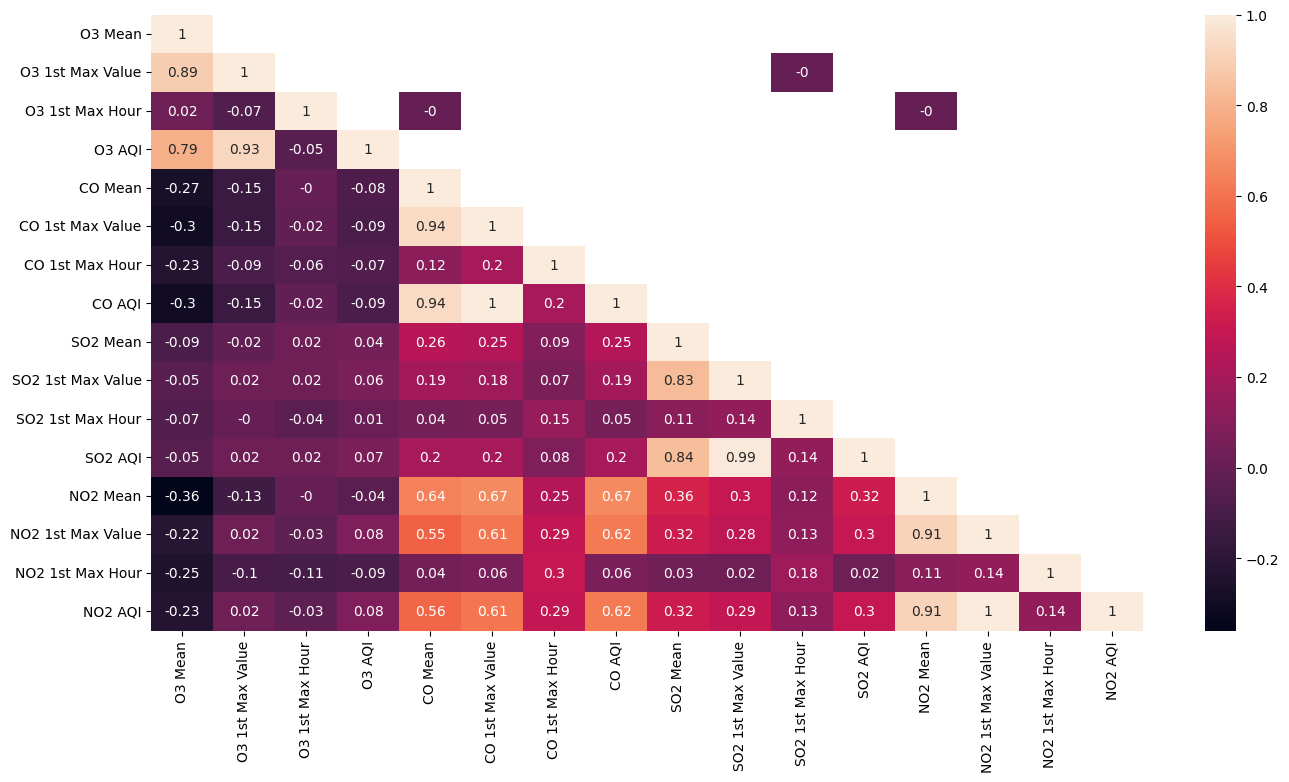

In [17]:
plt.figure(figsize = (16, 8))
correlation_matrix = us_pollution_dataset.drop(columns = ['Date']).corr(numeric_only = True).round(2)
sns.heatmap(correlation_matrix, annot = True, cmap = 'rocket', mask = np.triu(correlation_matrix, 1))
plt.show()

# Detailed Heatmap Analysis

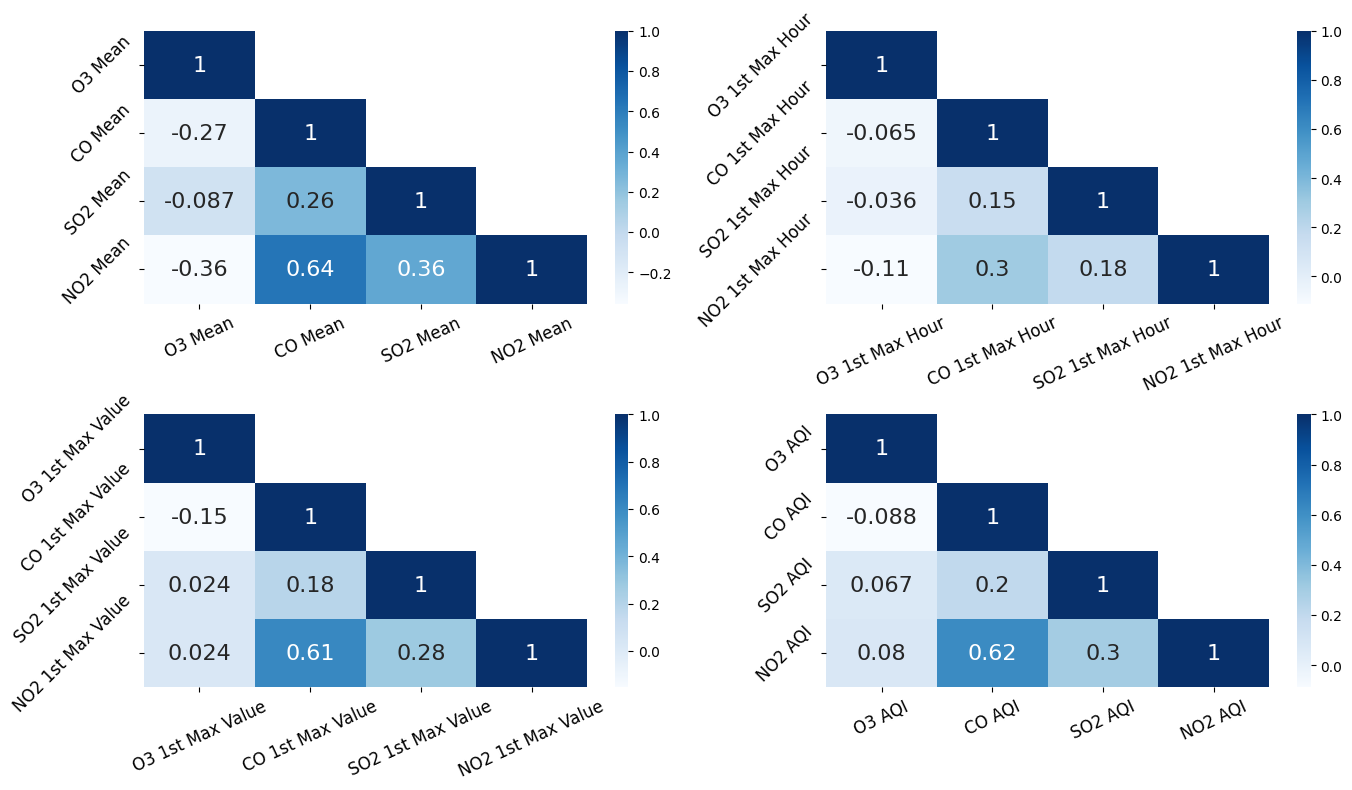

In [18]:
fig, ax = plt.subplots(2, 2, figsize = (14, 8))
ax = ax.flatten()

for i, columns in enumerate(category_columns.values()):
  correlation_matrix = us_pollution_dataset[columns].corr(numeric_only = True)
  sns.heatmap(correlation_matrix, annot = True, cmap = 'Blues', mask = np.triu(correlation_matrix, 1), annot_kws = {"size": 16}, ax = ax[i])
  ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation = 45, fontsize = 12)
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = 25, fontsize = 12)

plt.tight_layout()
plt.show()

### IMP observations
1. CO Mean & NO2 Mean are positively correlated.
2. CO AQI & NO2 AQI are positively correlated.
3. First hour max values of O3, NO2, & CO does not show wrong relations; signaling that the emission time of each polllutant might differ.
4. First max value of CO & NO2 also shows strong correlation.

# Distribution Analysis

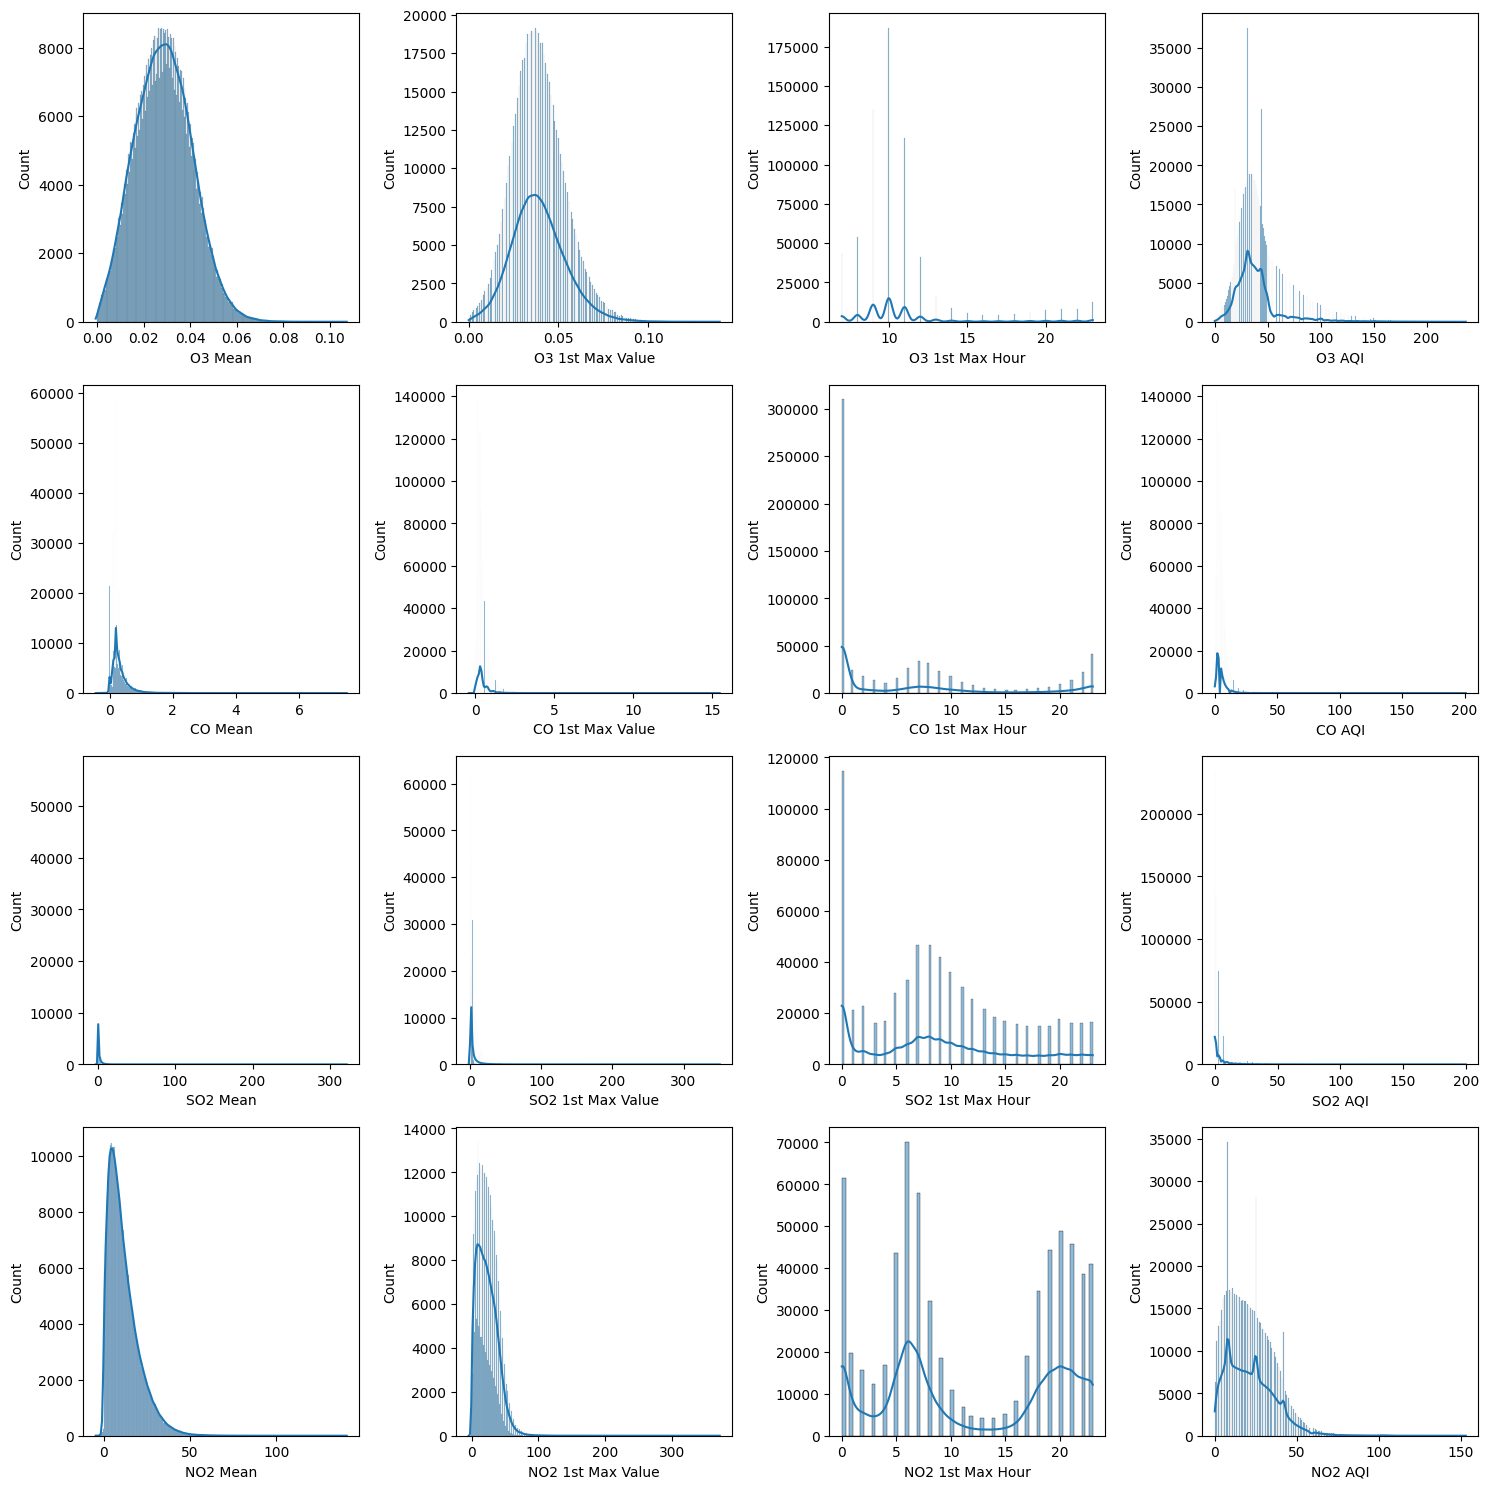

In [19]:
fig, ax = plt.subplots(4, 4, figsize = (15, 15))
ax = ax.flatten()

for i, column in enumerate(us_pollution_dataset.iloc[:, 5:21]):
  sns.histplot(us_pollution_dataset[column], ax = ax[i], kde = True)

plt.tight_layout()
plt.show()

# Boxplot Analysis

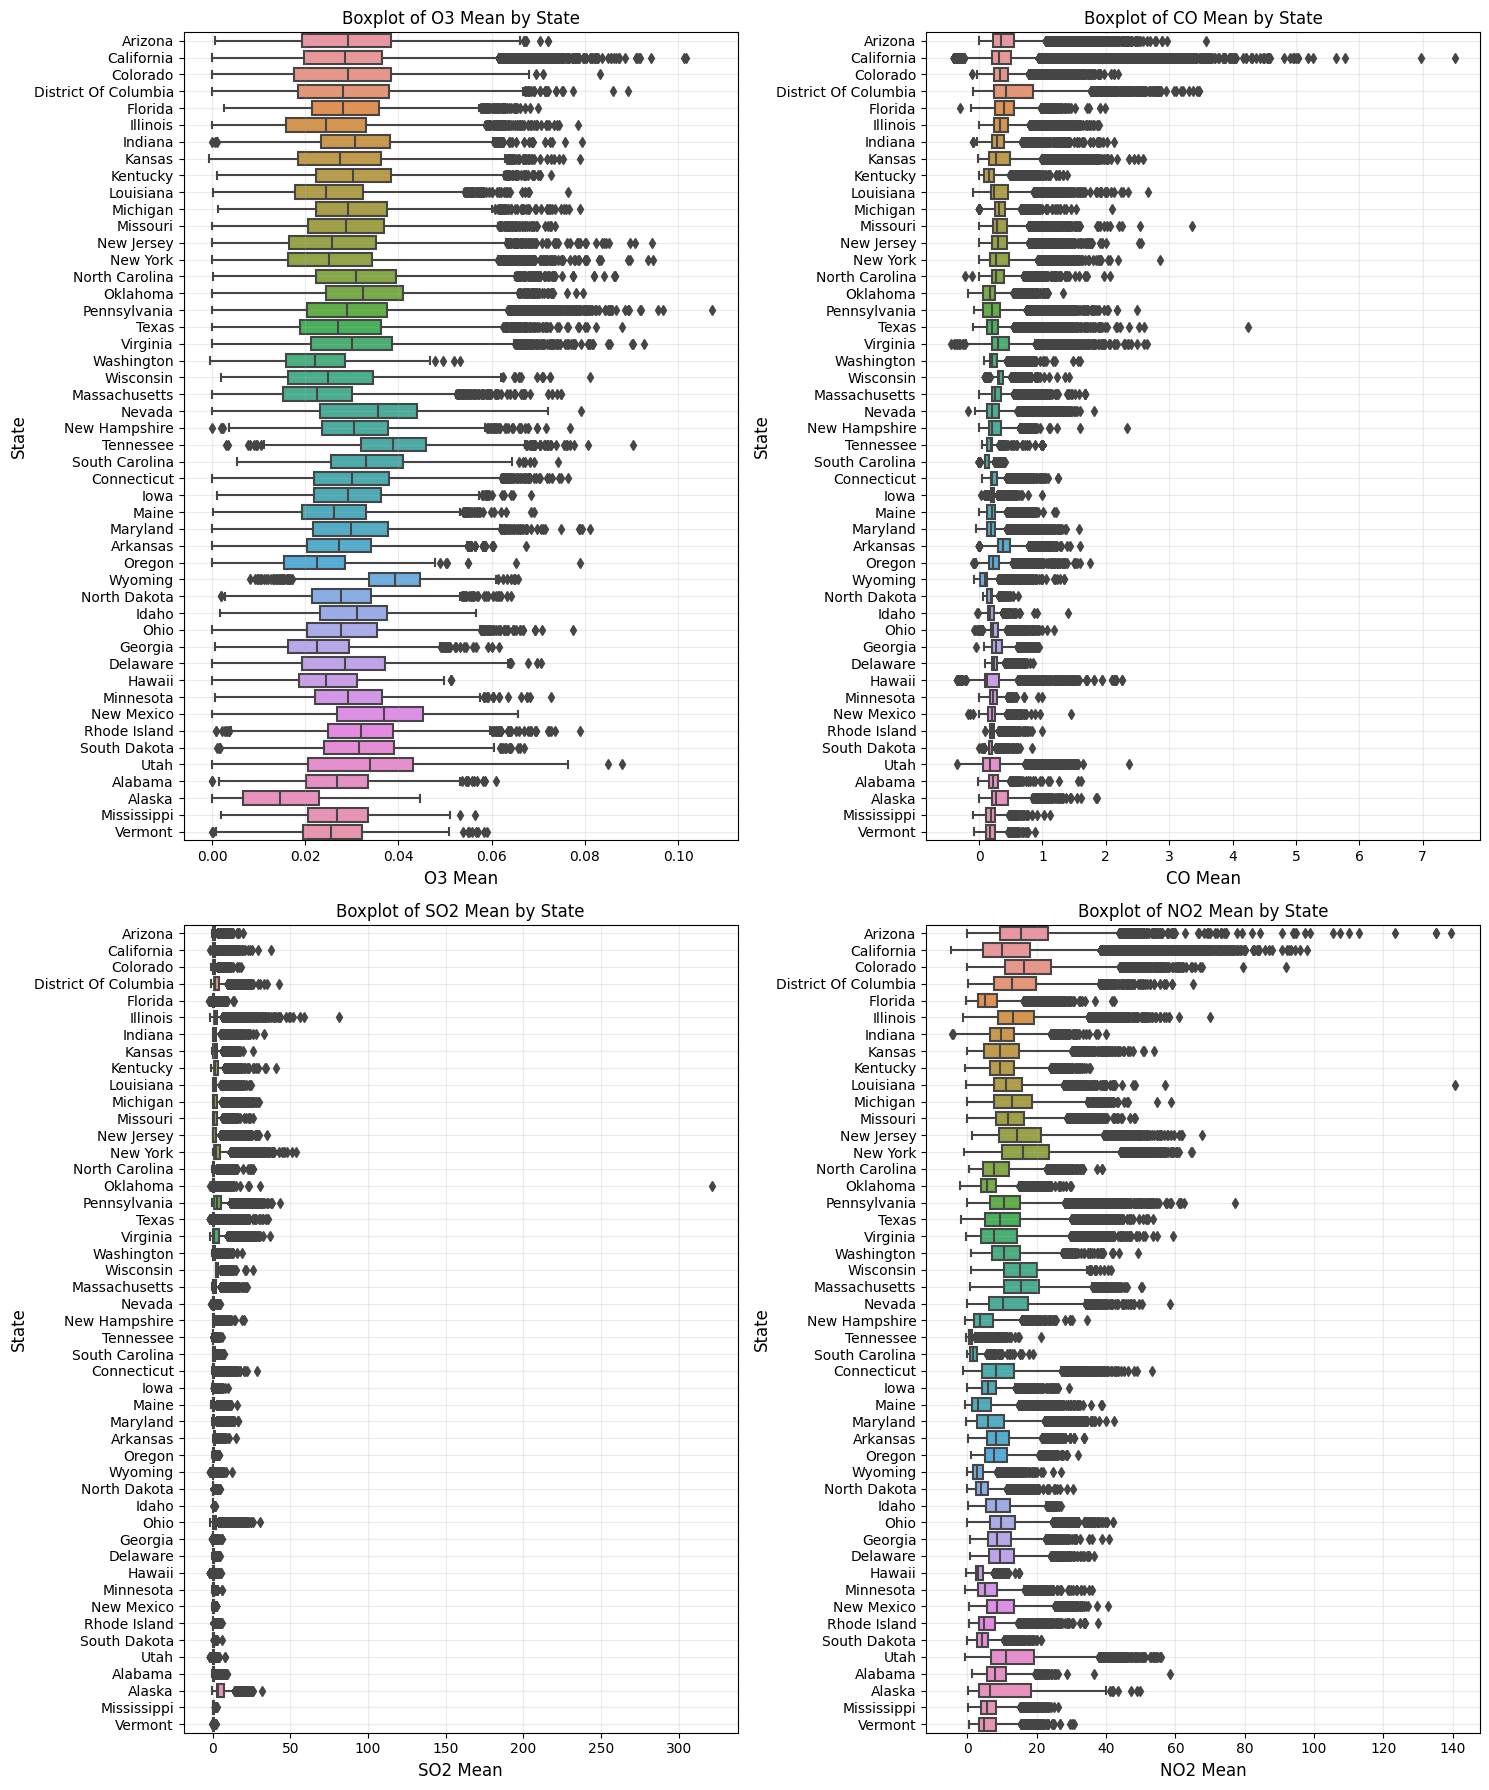

In [20]:
fig, ax = plt.subplots(2, 2, figsize = (15, 18))
ax = ax.flatten()

for i, column in enumerate(mean_columns):
  sns.boxplot(x = us_pollution_dataset[column], y = us_pollution_dataset['State'], data = us_pollution_dataset, ax = ax[i], orient = 'h')
  ax[i].set_title(f"Boxplot of {column} by State", fontsize = 12)
  ax[i].set_ylabel("State", fontsize = 12)
  ax[i].set_xlabel(column, fontsize = 12)
  ax[i].tick_params(axis = 'x', rotation = 0, labelsize = 10)
  ax[i].grid(alpha = 0.25)

plt.tight_layout()
plt.show()

### IMP Analysis
1. NO2 mean shows a stable distribution across most states except a few where significant outliers can be observed.
2. O3 mean shows similar median level across most states that indicates high levels of O3 occasionaly.
3. Mean value of CO varies noticeably across states. Most of the states have stable conditions with a broad interquantile range, indicates more variablity.

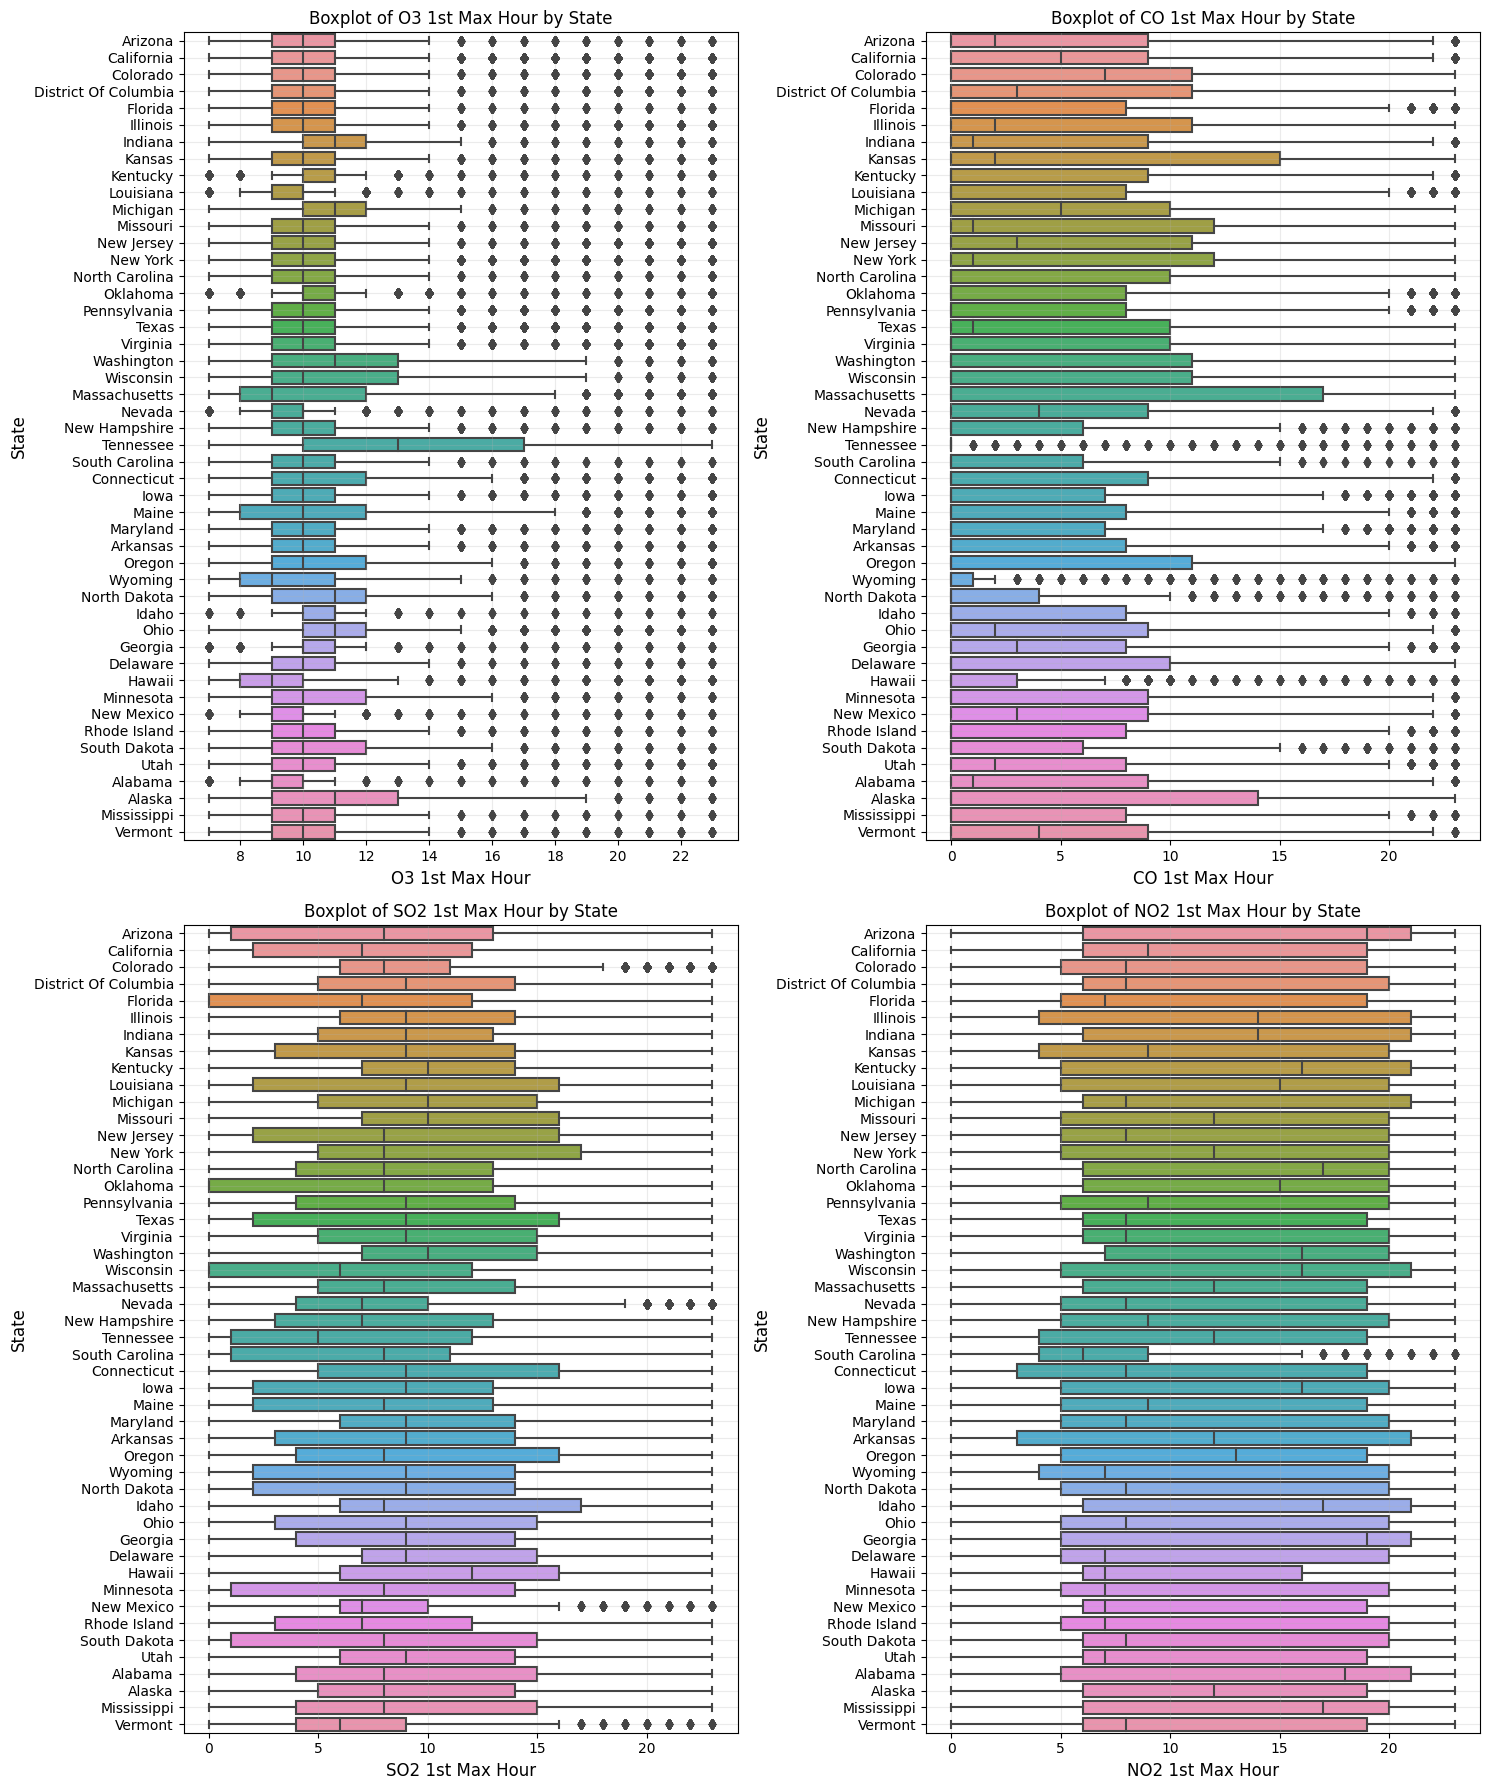

In [21]:
fig, ax = plt.subplots(2, 2, figsize = (15, 18))
ax = ax.flatten()

for i, column in enumerate(hour_columns):
  sns.boxplot(x = us_pollution_dataset[column], y = us_pollution_dataset['State'], data = us_pollution_dataset, ax = ax[i], orient = 'h')
  ax[i].set_title(f"Boxplot of {column} by State", fontsize = 12)
  ax[i].set_ylabel("State", fontsize = 12)
  ax[i].set_xlabel(column, fontsize = 12)
  ax[i].tick_params(axis = 'x', rotation = 0, labelsize = 10)
  ax[i].grid(alpha = 0.25)

plt.tight_layout()
plt.show()

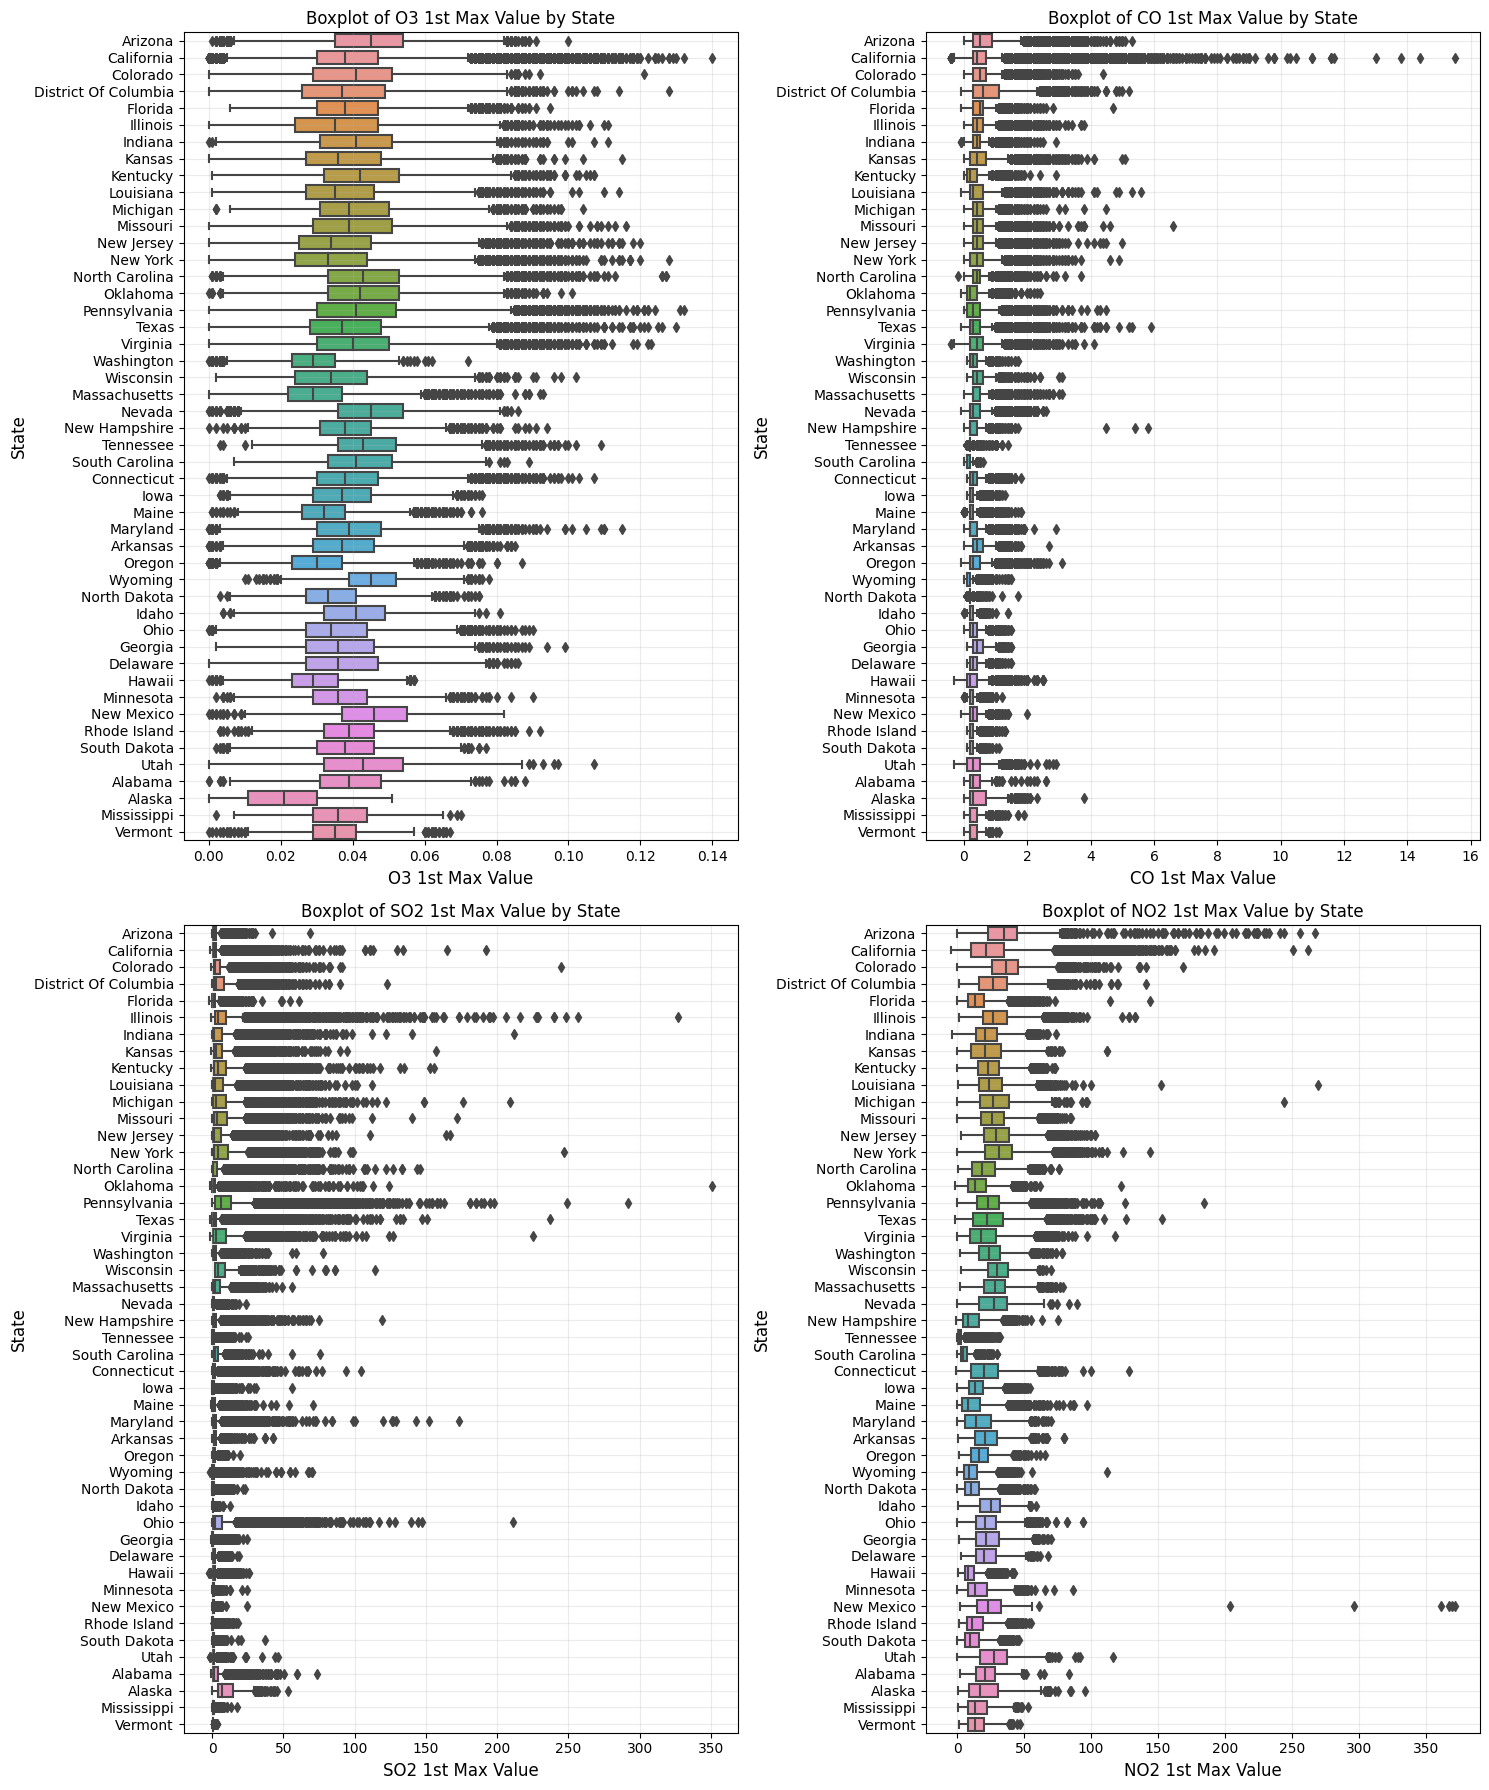

In [22]:
fig, ax = plt.subplots(2, 2, figsize = (15, 18))
ax = ax.flatten()

for i, column in enumerate(value_columns):
  sns.boxplot(x = us_pollution_dataset[column], y = us_pollution_dataset['State'], data = us_pollution_dataset, ax = ax[i], orient = 'h')
  ax[i].set_title(f"Boxplot of {column} by State", fontsize = 12)
  ax[i].set_ylabel("State", fontsize = 12)
  ax[i].set_xlabel(column, fontsize = 12)
  ax[i].tick_params(axis = 'x', rotation = 0, labelsize = 10)
  ax[i].grid(alpha = 0.25)

plt.tight_layout()
plt.show()

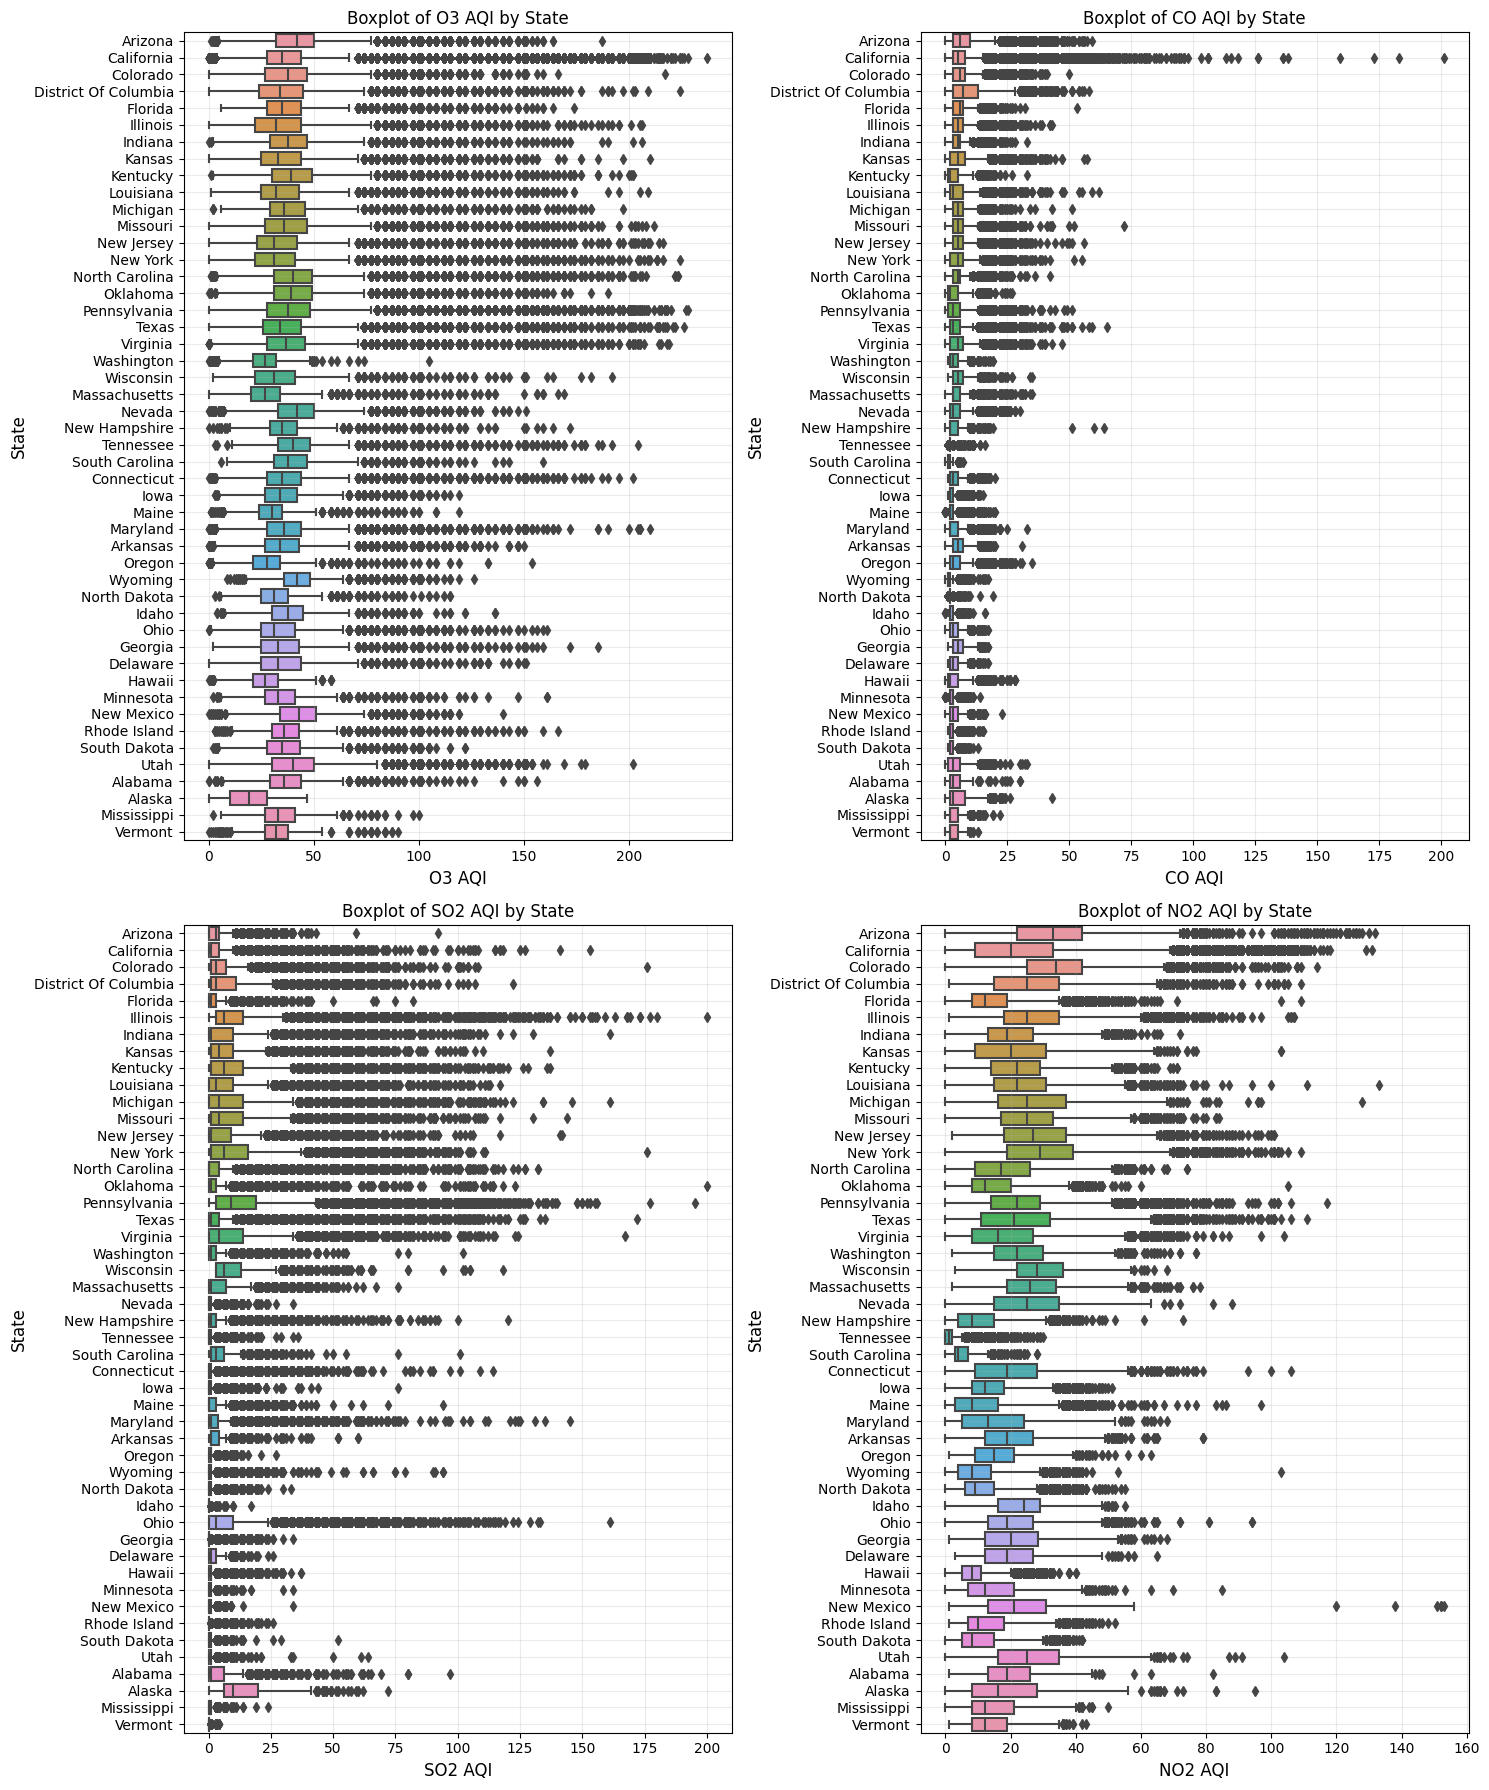

In [23]:
fig, ax = plt.subplots(2, 2, figsize = (15, 18))
ax = ax.flatten()

for i, column in enumerate(aqi_columns):
  sns.boxplot(x = us_pollution_dataset[column], y = us_pollution_dataset['State'], data = us_pollution_dataset, ax = ax[i], orient = 'h')
  ax[i].set_title(f"Boxplot of {column} by State", fontsize = 12)
  ax[i].set_ylabel("State", fontsize = 12)
  ax[i].set_xlabel(column, fontsize = 12)
  ax[i].tick_params(axis = 'x', rotation = 0, labelsize = 10)
  ax[i].grid(alpha = 0.25)

plt.tight_layout()
plt.show()

### IMP Observations
1. O3, SO2, & NO2 AQI level shows a considerable numbers of outliers, indicating sudden increase in the pollutants level.
2. Most states have an approximately similar CO mean value, but there are also a significant outliers present across many states.
3. SO2 AQI levels shows aggressive outliers presence.

# Mann-Kendall Test

In [24]:
numerical_columns = us_pollution_dataset.select_dtypes(include=['float64', 'int64']).columns

Mann-Kendall Test for O3 Mean:
Tau: 0.03830753449064771
P-Value: 0.0
There is a significant trend in the data.


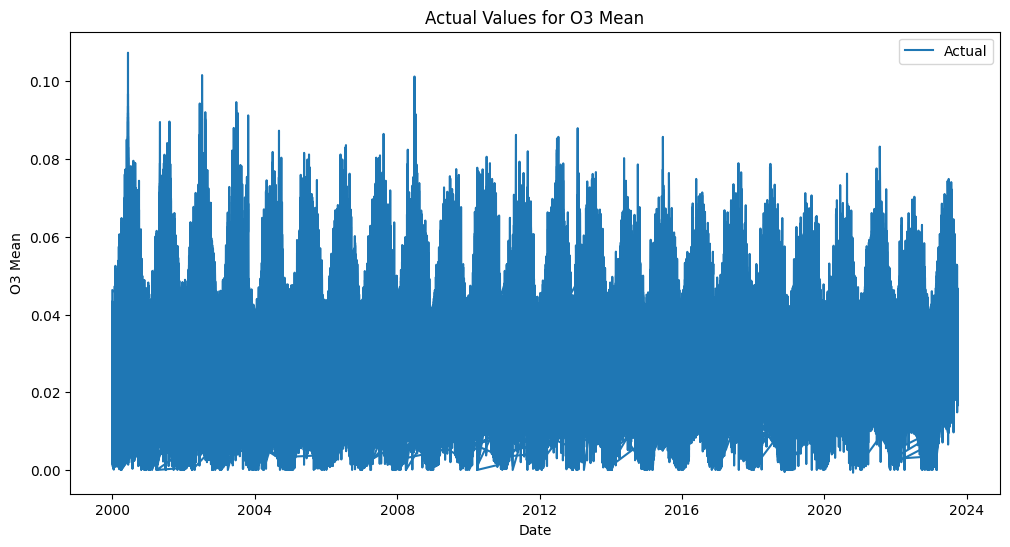



Mann-Kendall Test for O3 1st Max Value:
Tau: -0.008492727543269222
P-Value: 7.765686493363334e-25
There is a significant trend in the data.


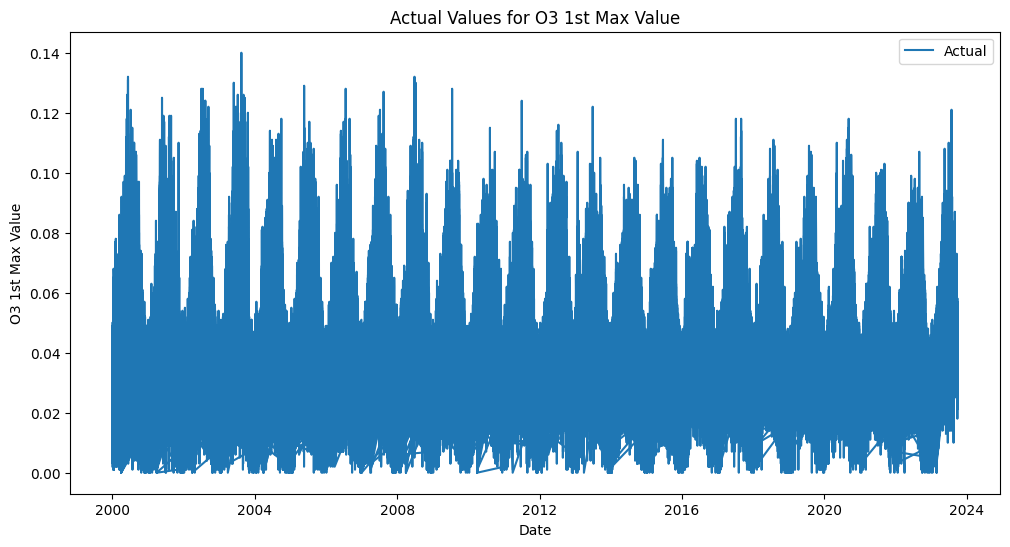



Mann-Kendall Test for O3 1st Max Hour:
Tau: -0.004658438019223376
P-Value: 1.165380619924314e-07
There is a significant trend in the data.


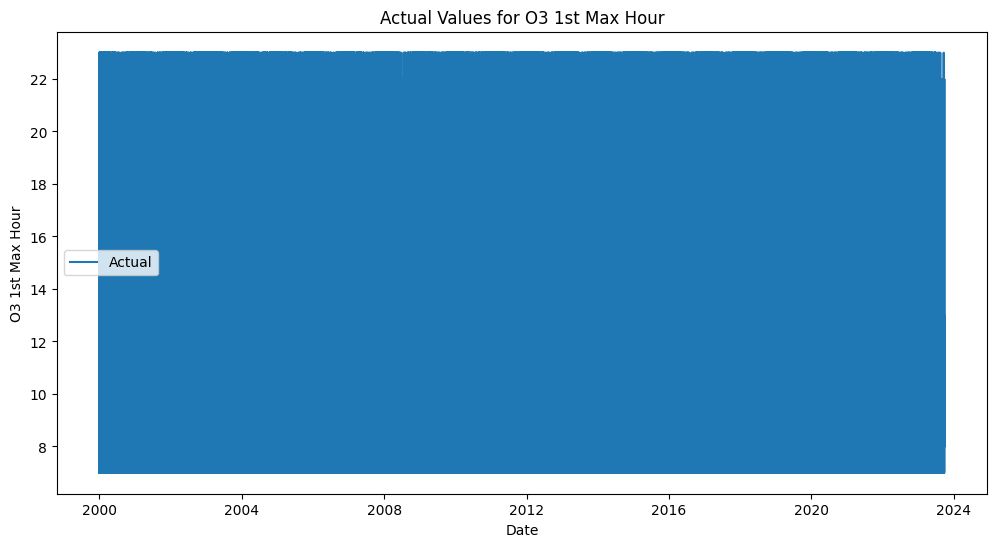



Mann-Kendall Test for O3 AQI:
Tau: -0.008400181925502239
P-Value: 2.836227746379787e-24
There is a significant trend in the data.


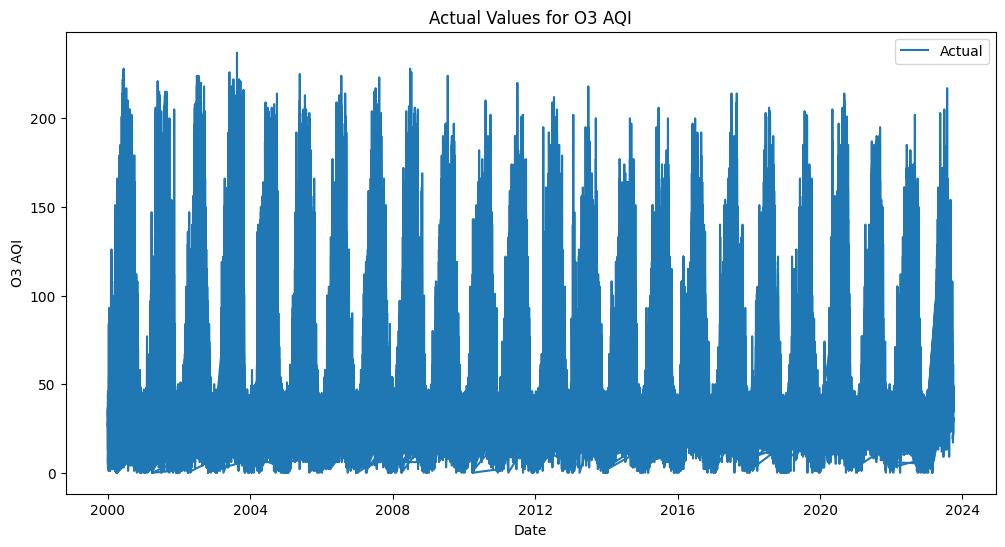



Mann-Kendall Test for CO Mean:
Tau: -0.1895482117908992
P-Value: 0.0
There is a significant trend in the data.


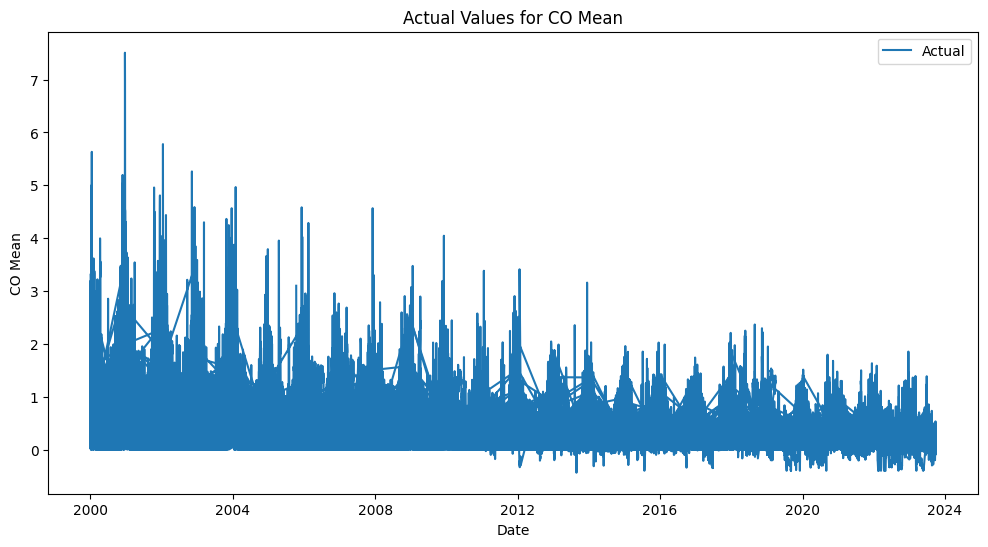



Mann-Kendall Test for CO 1st Max Value:
Tau: -0.20519046531788035
P-Value: 0.0
There is a significant trend in the data.


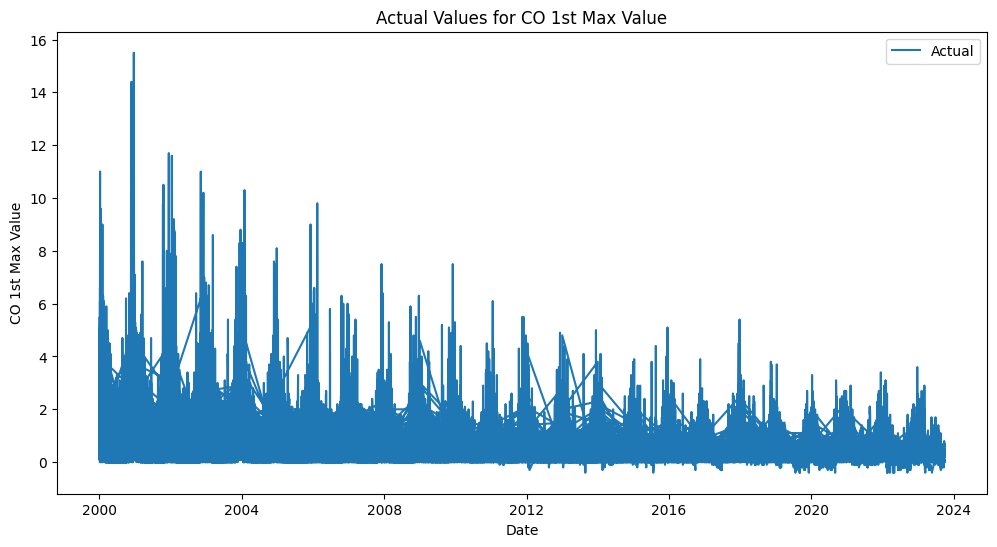



Mann-Kendall Test for CO 1st Max Hour:
Tau: -0.07370616082434765
P-Value: 0.0
There is a significant trend in the data.


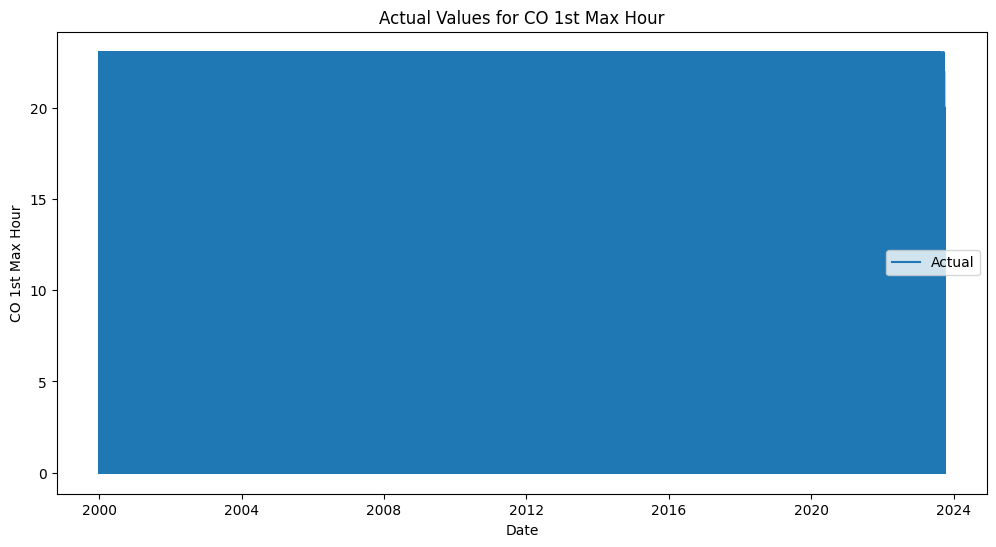



Mann-Kendall Test for CO AQI:
Tau: -0.20513223546300516
P-Value: 0.0
There is a significant trend in the data.


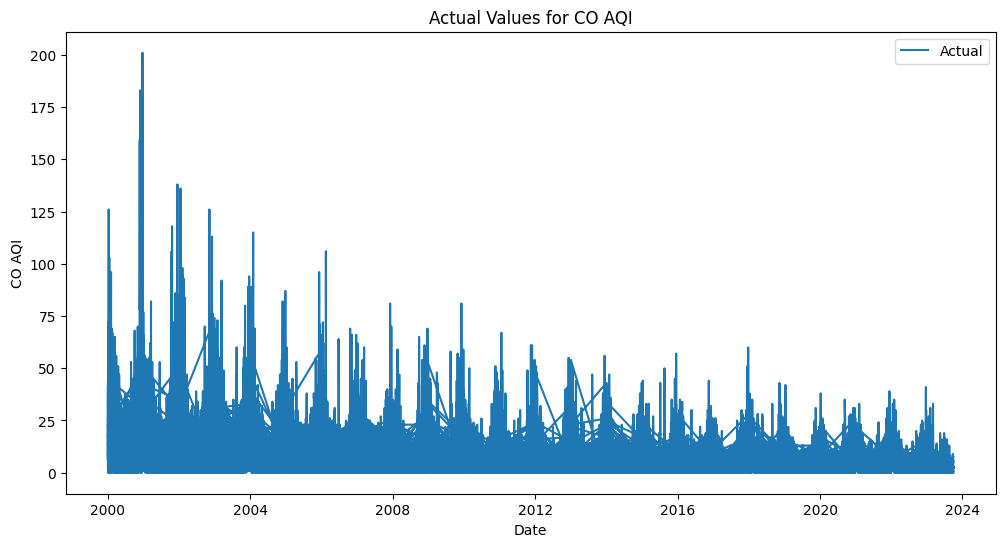



Mann-Kendall Test for SO2 Mean:
Tau: -0.3073154719083334
P-Value: 0.0
There is a significant trend in the data.


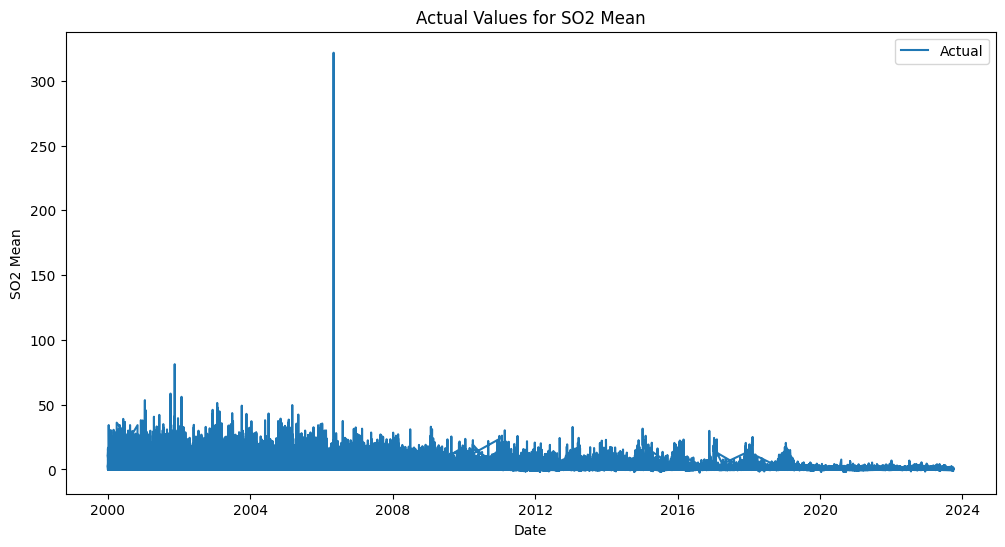



Mann-Kendall Test for SO2 1st Max Value:
Tau: -0.3565997426825535
P-Value: 0.0
There is a significant trend in the data.


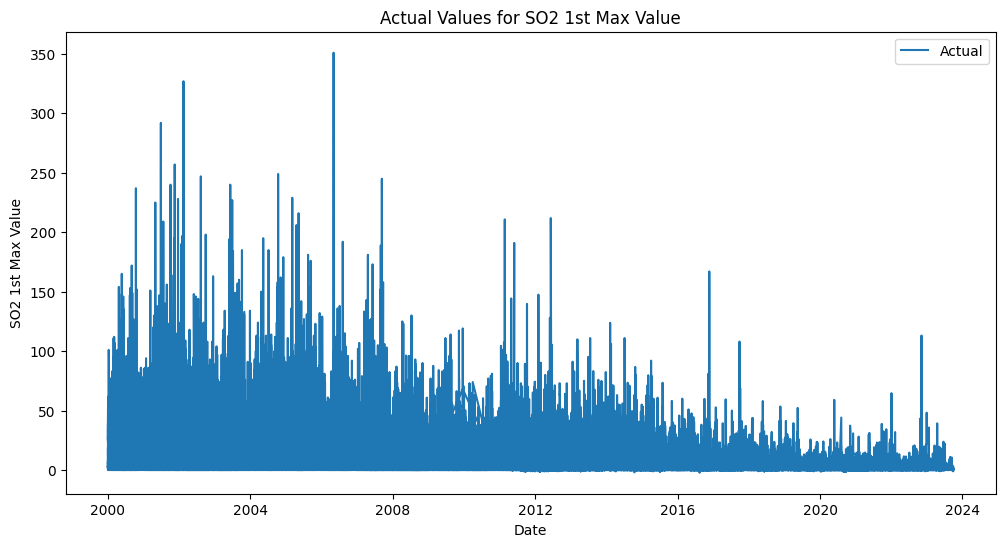



Mann-Kendall Test for SO2 1st Max Hour:
Tau: 0.017522202977128448
P-Value: 4.0851603977258515e-96
There is a significant trend in the data.


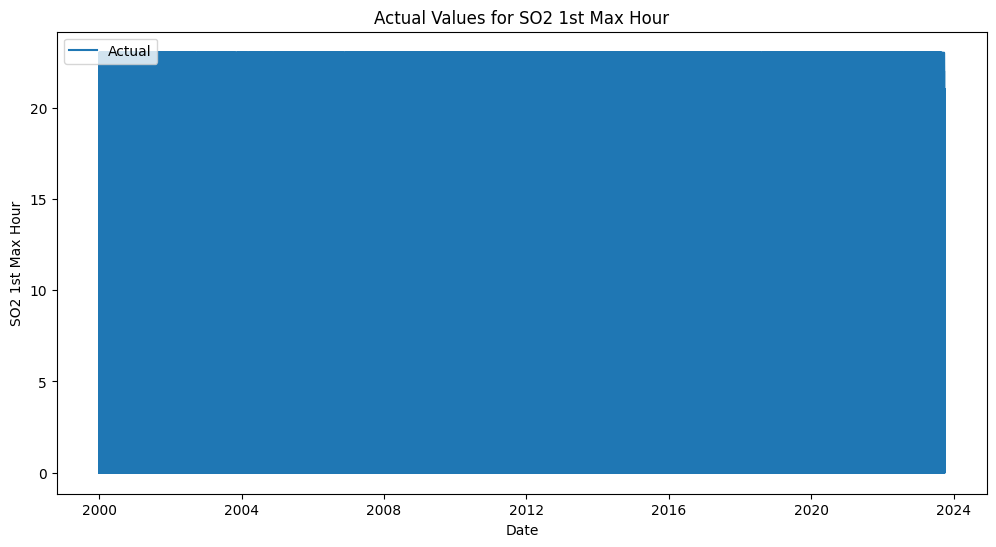



Mann-Kendall Test for SO2 AQI:
Tau: -0.4283727339331035
P-Value: 0.0
There is a significant trend in the data.


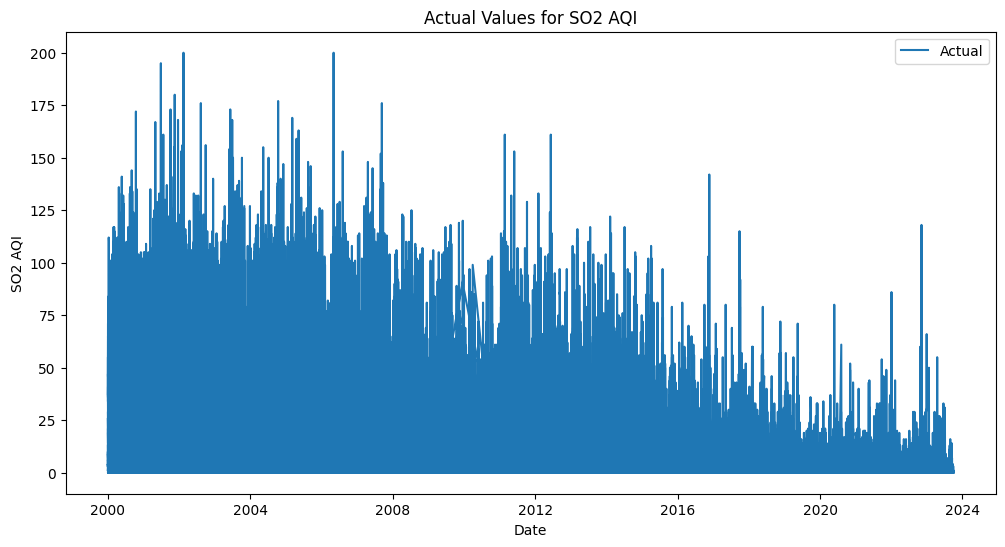



Mann-Kendall Test for NO2 Mean:
Tau: -0.1975955983445713
P-Value: 0.0
There is a significant trend in the data.


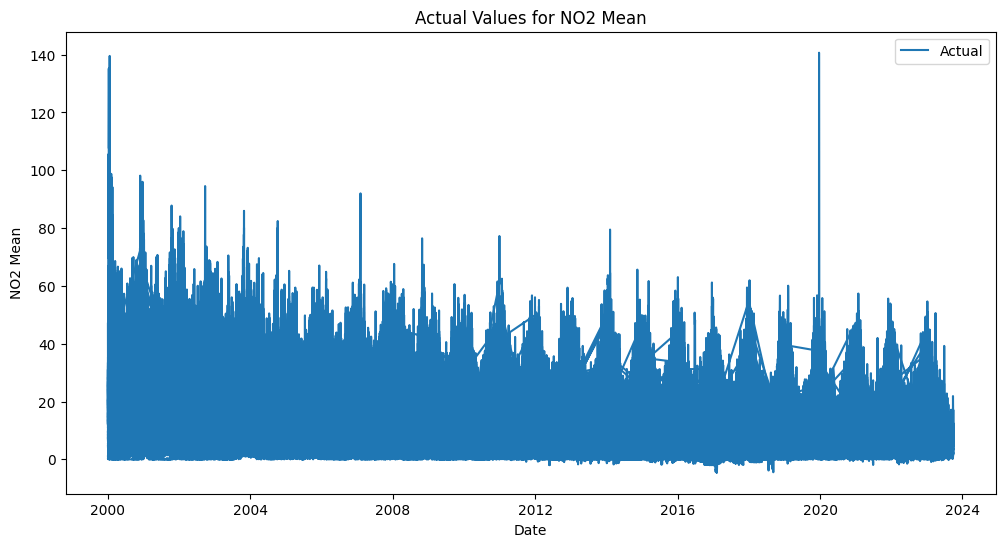



Mann-Kendall Test for NO2 1st Max Value:
Tau: -0.17976196103531636
P-Value: 0.0
There is a significant trend in the data.


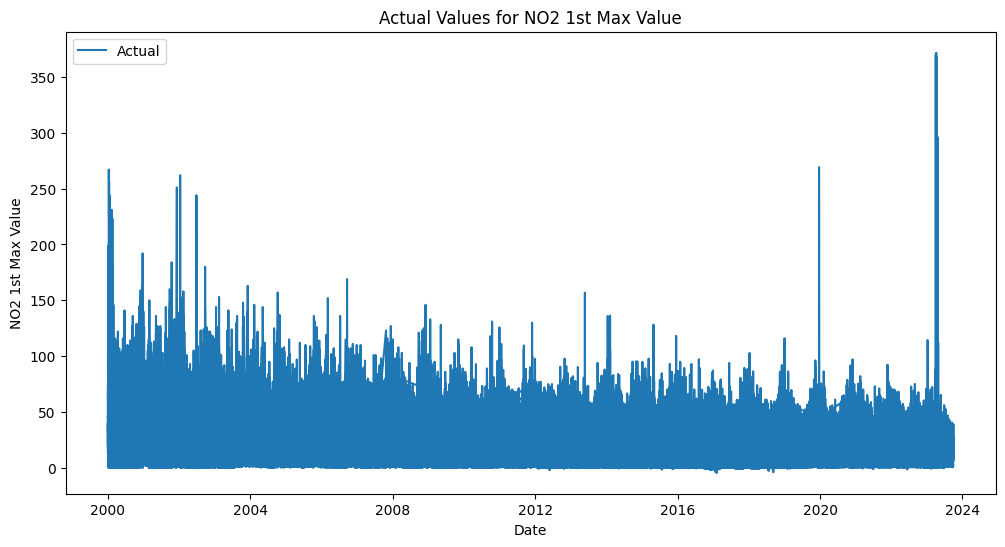



Mann-Kendall Test for NO2 1st Max Hour:
Tau: -0.019041556535052653
P-Value: 3.927434819381587e-113
There is a significant trend in the data.


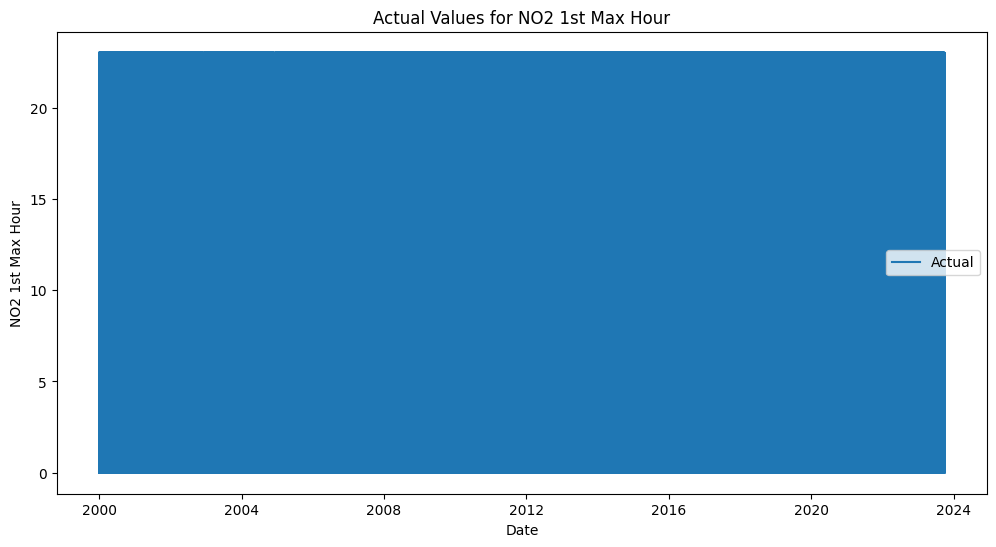



Mann-Kendall Test for NO2 AQI:
Tau: -0.18829309062124114
P-Value: 0.0
There is a significant trend in the data.


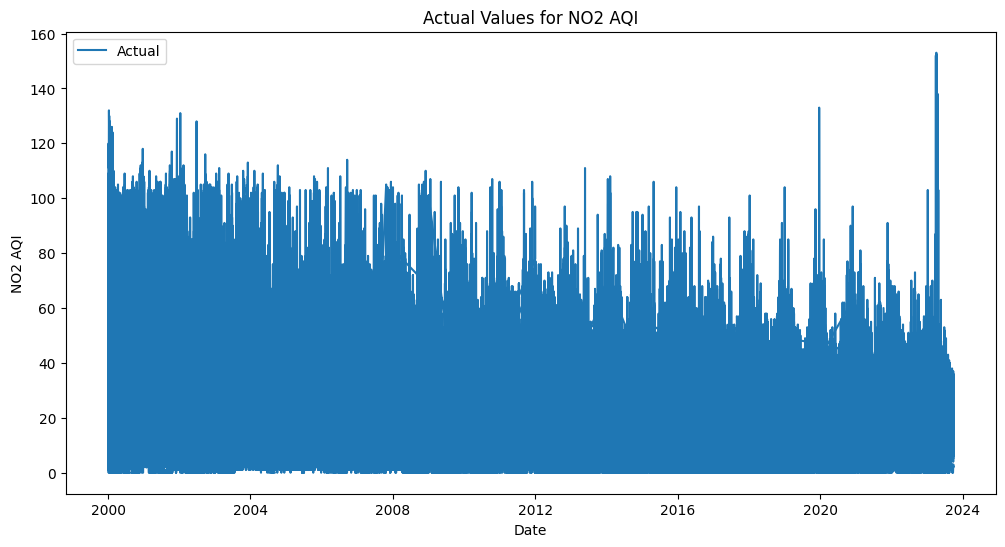

In [25]:
for column_totest in numerical_columns:
  tau, p_value = kendalltau(us_pollution_dataset['Date'], us_pollution_dataset[column_totest])

  print(f'Mann-Kendall Test for {column_totest}:')
  print(f'Tau: {tau}')
  print(f'P-Value: {p_value}')

  if p_value <= 0.05:
      print('There is a significant trend in the data.')
  else:
      print('There is no significant trend in the data.')


  plt.figure(figsize=(12, 6))
  plt.plot(us_pollution_dataset['Date'], us_pollution_dataset[column_totest], label='Actual')
  plt.xlabel('Date')
  plt.ylabel(column_totest)
  plt.title(f'Actual Values for {column_totest}')
  plt.legend()
  plt.show()
  print('\n')

# Spearman Correlation Test

In [26]:
features_of_interest =['O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI']

In [27]:
selected_data = us_pollution_dataset[features_of_interest]

In [28]:
correlation_matrix, p_values = spearmanr(selected_data)

In [29]:
correlation_results = pd.DataFrame(correlation_matrix, columns = features_of_interest, index = features_of_interest)
p_values_df = pd.DataFrame(p_values, columns = features_of_interest, index = features_of_interest)

In [30]:
print("Spearman Correlation Matrix:\n")
print(correlation_results)

Spearman Correlation Matrix:

                   O3 Mean  O3 1st Max Value  O3 1st Max Hour    O3 AQI
O3 Mean           1.000000          0.884216         0.192166  0.883935
O3 1st Max Value  0.884216          1.000000         0.137336  0.999607
O3 1st Max Hour   0.192166          0.137336         1.000000  0.137717
O3 AQI            0.883935          0.999607         0.137717  1.000000


### Spearman Correlation Matrix Significance
> It indicates that the probability of observing such strong correlations by random chance is extremely low.

> O3 Mean and First Max Value of O3 have a strong positive correlation.

> O3 Mean and O3 AQI have a strong positive correlation.

> First Max Value of O3 and O3 AQI have a very strong positive correlation.

> First Max Value of O3 has a weak positive correlation with other variables.

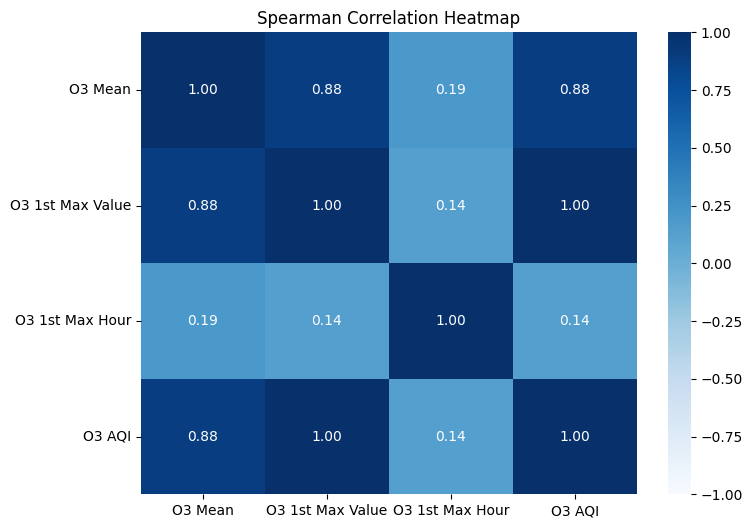

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_results, annot = True, cmap = 'Blues', fmt = ".2f", vmin = -1, vmax = 1)
plt.title('Spearman Correlation Heatmap')
plt.show()

In [32]:
print("P-Values:")
print(p_values_df)

P-Values:
                  O3 Mean  O3 1st Max Value  O3 1st Max Hour  O3 AQI
O3 Mean               0.0               0.0              0.0     0.0
O3 1st Max Value      0.0               0.0              0.0     0.0
O3 1st Max Hour       0.0               0.0              0.0     0.0
O3 AQI                0.0               0.0              0.0     0.0


# Basic Trend Analysis

In [33]:
year_range = us_pollution_dataset
year_range['Date'] = year_range['Date'].dt.year
year_range.head()

,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,2000,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,10,37,0.878947,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,2000,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,10,30,1.066667,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2000,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,9,15,1.762500,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,2000,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,9,31,1.829167,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,2000,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,9,11,2.700000,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58


In [34]:
year_range = us_pollution_dataset.groupby(['Address', 'State'])['Date'].agg(['min', 'max']).reset_index()
year_range = year_range[(year_range['min'] <= 2018) & (year_range['max'] == 2023)]
year_range.sort_values(by = 'min')

,Address,State,min,max
9,"1029 ETHEL ST, CALEXICO HIGH SCHOOL",California,2000,2023
76,2956-A TREAT BOULEVARD,California,2000,2023
102,4103 BEACON HILL S,Washington,2000,2023
120,5551 BETHEL ISLAND RD,California,2000,2023
125,"5888 MISSION BLVD., RUBIDOUX",California,2000,2023
...,...,...,...,...
44,1810 N 16TH STREET,North Dakota,2016,2023
154,"96 STATE STREET, Rutland, Vermont",Vermont,2016,2023
104,4250 Karen Ave,Nevada,2017,2023
26,1250 NORTH 1400 WEST,Utah,2018,2023


In [35]:
combined_year_range = pd.merge(year_range, us_pollution_dataset, on = ['Address', 'State'], how = 'inner')
combined_year_range.head()

,Address,State,min,max,Date,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,"1029 ETHEL ST, CALEXICO HIGH SCHOOL",California,2000,2023,2000,Imperial,Calexico,0.035647,0.041,10,...,11,9.0,0.391304,3.0,8,4.0,9.304348,24.0,7,23
1,"1029 ETHEL ST, CALEXICO HIGH SCHOOL",California,2000,2023,2000,Imperial,Calexico,0.027000,0.040,8,...,21,6.0,0.000000,0.0,0,0.0,10.000000,25.0,17,24
2,"1029 ETHEL ST, CALEXICO HIGH SCHOOL",California,2000,2023,2000,Imperial,Calexico,0.017588,0.035,9,...,22,32.0,1.086957,6.0,20,9.0,23.304348,51.0,19,48
3,"1029 ETHEL ST, CALEXICO HIGH SCHOOL",California,2000,2023,2000,Imperial,Calexico,0.015529,0.033,9,...,0,33.0,1.217391,5.0,8,7.0,24.913043,51.0,8,48
4,"1029 ETHEL ST, CALEXICO HIGH SCHOOL",California,2000,2023,2000,Imperial,Calexico,0.017176,0.031,9,...,0,30.0,0.782609,4.0,7,6.0,24.173913,42.0,17,40


In [36]:
pollutant_column = ['O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI', 'NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI']

In [37]:
combined_year_range['Complete Address'] = combined_year_range['Address'] + ',' +  combined_year_range['State']
combined_year_range.drop(['Address', 'State'], axis = 1, inplace = True)
combined_year_range.head()

,min,max,Date,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,...,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,Complete Address
0,2000,2023,2000,Imperial,Calexico,0.035647,0.041,10,38,0.494444,...,9.0,0.391304,3.0,8,4.0,9.304348,24.0,7,23,"1029 ETHEL ST, CALEXICO HIGH SCHOOL,California"
1,2000,2023,2000,Imperial,Calexico,0.027000,0.040,8,37,0.366667,...,6.0,0.000000,0.0,0,0.0,10.000000,25.0,17,24,"1029 ETHEL ST, CALEXICO HIGH SCHOOL,California"
2,2000,2023,2000,Imperial,Calexico,0.017588,0.035,9,32,1.175000,...,32.0,1.086957,6.0,20,9.0,23.304348,51.0,19,48,"1029 ETHEL ST, CALEXICO HIGH SCHOOL,California"
3,2000,2023,2000,Imperial,Calexico,0.015529,0.033,9,31,1.525000,...,33.0,1.217391,5.0,8,7.0,24.913043,51.0,8,48,"1029 ETHEL ST, CALEXICO HIGH SCHOOL,California"
4,2000,2023,2000,Imperial,Calexico,0.017176,0.031,9,29,1.391667,...,30.0,0.782609,4.0,7,6.0,24.173913,42.0,17,40,"1029 ETHEL ST, CALEXICO HIGH SCHOOL,California"


In [38]:
linear_regression_analysis = []

In [39]:
for address, group in combined_year_range.groupby('Complete Address'):
  for column in pollutant_column:
    try:
      X = sm.add_constant(group['Date'])
      y = group[column]

      model = sm.OLS(y, X)
      history = model.fit()

      linear_regression_analysis.append({'address': address, 'Pollutant Metrics': column, 'slope': history.params['Date'], 'intercept': history.params['const']})
    except:
      pass

In [40]:
linear_regression_dataframe = pd.DataFrame(linear_regression_analysis)
linear_regression_dataframe.head()

,address,Pollutant Metrics,slope,intercept
0,"1029 ETHEL ST, CALEXICO HIGH SCHOOL,California",O3 Mean,0.000359,-0.692375
1,"1029 ETHEL ST, CALEXICO HIGH SCHOOL,California",O3 1st Max Value,0.000364,-0.687521
2,"1029 ETHEL ST, CALEXICO HIGH SCHOOL,California",O3 1st Max Hour,0.004926,-0.301626
3,"1029 ETHEL ST, CALEXICO HIGH SCHOOL,California",O3 AQI,0.400538,-760.401070
4,"1029 ETHEL ST, CALEXICO HIGH SCHOOL,California",CO Mean,-0.035220,71.435540


In [41]:
linear_regression_dataframe['Pollutant Metrics'].unique()

array(['O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI',
       'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI',
       'NO2 Mean', 'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI'],
      dtype=object)

# Linear Relation Analysis

In [42]:
max_slope_O3_mean = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'O3 Mean'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_O3_max_value = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'O3 1st Max Value'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_O3_max_hour = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'O3 1st Max Hour'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_O3_AQI = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'O3 AQI'].sort_values(by = 'slope', ascending = False).head(3)

linear_O3_dataframe = [max_slope_O3_mean, max_slope_O3_max_value, max_slope_O3_max_hour, max_slope_O3_AQI]

linear_analysis_O3_dataframe = pd.concat(linear_O3_dataframe, axis = 0)

print(linear_analysis_O3_dataframe)

                           address Pollutant Metrics     slope    intercept
624       4545 Navajo St.,Colorado           O3 Mean  0.001071    -2.131935
736       750 DUNDEE ROAD,Illinois           O3 Mean  0.000920    -1.823337
304         2105 BROADWAY,Colorado           O3 Mean  0.000829    -1.643098
625       4545 Navajo St.,Colorado  O3 1st Max Value  0.001025    -2.027396
737       750 DUNDEE ROAD,Illinois  O3 1st Max Value  0.000945    -1.864626
305         2105 BROADWAY,Colorado  O3 1st Max Value  0.000883    -1.742988
578          4250 Karen Ave,Nevada   O3 1st Max Hour  0.076485  -144.606317
562  4103 BEACON HILL S,Washington   O3 1st Max Hour  0.058015  -104.953326
786        8449 S. Monroe St.,Utah   O3 1st Max Hour  0.045658   -81.636729
627       4545 Navajo St.,Colorado            O3 AQI  1.417801 -2819.786224
739       750 DUNDEE ROAD,Illinois            O3 AQI  1.214395 -2405.881449
307         2105 BROADWAY,Colorado            O3 AQI  1.028823 -2037.211320


### Major areas emitting O3
1. 4545 Navajo St.,Colorado
2. 750 DUNDEE ROAD,Illinois
3. 2105 BROADWAY,Colorado

In [43]:
max_slope_CO_mean = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'CO Mean'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_CO_max_value = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'CO 1st Max Value'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_CO_max_hour = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'CO 1st Max Hour'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_CO_AQI = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'CO AQI'].sort_values(by = 'slope', ascending = False).head(3)

linear_CO_dataframe = [max_slope_CO_mean, max_slope_CO_max_value, max_slope_CO_max_hour, max_slope_CO_AQI]

linear_analysis_CO_dataframe = pd.concat(linear_CO_dataframe, axis = 0)
linear_analysis_CO_dataframe

,address,Pollutant Metrics,slope,intercept
372,2501 E. Memorial Rd. (OKLAHOMA CHRISTIAN UNIV...,CO Mean,0.021521,-43.147913
836,"96 STATE STREET, Rutland, Vermont,Vermont",CO Mean,0.019174,-38.523670
388,"266-298 Spruce Street,New Jersey",CO Mean,0.013732,-27.461429
373,2501 E. Memorial Rd. (OKLAHOMA CHRISTIAN UNIV...,CO 1st Max Value,0.020403,-40.835210
837,"96 STATE STREET, Rutland, Vermont,Vermont",CO 1st Max Value,0.019131,-38.361561
389,"266-298 Spruce Street,New Jersey",CO 1st Max Value,0.016212,-32.376167
102,"1250 NORTH 1400 WEST,Utah",CO 1st Max Hour,0.319968,-641.547993
390,"266-298 Spruce Street,New Jersey",CO 1st Max Hour,0.091682,-179.503933
166,"150 Pillsbury Rd,New Hampshire",CO 1st Max Hour,0.089076,-176.782600
375,2501 E. Memorial Rd. (OKLAHOMA CHRISTIAN UNIV...,CO AQI,0.256853,-514.478011


### Major areas emitting CO
1. 2501 E. Memorial Rd.  (OKLAHOMA CHRISTIAN UNIV
2. 96 STATE STREET, Rutland, Vermont,Vermont
3. 266-298 Spruce Street,New Jersey

In [44]:
max_slope_SO2_mean = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'SO2 Mean'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_SO2_max_value = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'SO2 1st Max Value'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_SO2_max_hour = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'SO2 1st Max Hour'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_SO2_AQI = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'SO2 AQI'].sort_values(by = 'slope', ascending = False).head(3)

linear_SO2_dataframe = [max_slope_SO2_mean, max_slope_SO2_max_value, max_slope_SO2_max_hour, max_slope_SO2_AQI]

linear_analysis_SO2_dataframe = pd.concat(linear_SO2_dataframe, axis = 0)
print(linear_analysis_SO2_dataframe)

                                       address  Pollutant Metrics     slope  \
792                    8449 S. Monroe St.,Utah           SO2 Mean  0.217630   
104                  1250 NORTH 1400 WEST,Utah           SO2 Mean  0.156149   
968     HERMAN HORN ELEMENTARY SCHOOL,Virginia           SO2 Mean  0.025694   
793                    8449 S. Monroe St.,Utah  SO2 1st Max Value  0.183437   
105                  1250 NORTH 1400 WEST,Utah  SO2 1st Max Value  0.139779   
841  96 STATE STREET, Rutland, Vermont,Vermont  SO2 1st Max Value -0.007894   
794                    8449 S. Monroe St.,Utah   SO2 1st Max Hour  1.373504   
106                  1250 NORTH 1400 WEST,Utah   SO2 1st Max Hour  0.864005   
394           266-298 Spruce Street,New Jersey   SO2 1st Max Hour  0.597421   
795                    8449 S. Monroe St.,Utah            SO2 AQI  0.114114   
107                  1250 NORTH 1400 WEST,Utah            SO2 AQI  0.074032   
843  96 STATE STREET, Rutland, Vermont,Vermont      

### Major areas emitting SO2
1. 8449 S. Monroe St.,Utah
2. 1250 NORTH 1400 WEST,Utah
3. 96 STATE STREET, Rutland, Vermont,Vermont

In [45]:
max_slope_NO2_mean = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'NO2 Mean'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_NO2_max_value = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'NO2 1st Max Value'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_NO2_max_hour = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'NO2 1st Max Hour'].sort_values(by = 'slope', ascending = False).head(3)
max_slope_NO2_AQI = linear_regression_dataframe[linear_regression_dataframe['Pollutant Metrics'] == 'NO2 AQI'].sort_values(by = 'slope', ascending = False).head(3)

linear_NO2_dataframe = [max_slope_NO2_mean, max_slope_NO2_max_value, max_slope_NO2_max_hour, max_slope_NO2_AQI]

linear_analysis_NO2_dataframe = pd.concat(linear_NO2_dataframe, axis = 0)
print(linear_analysis_NO2_dataframe)

                                           address  Pollutant Metrics  \
300                     2052 LAUWILIWILI ST,Hawaii           NO2 Mean   
1036       NARSTO SITE - ARENDTSVILLE,Pennsylvania           NO2 Mean   
668             520 S. EAGLE ROAD,  MERIDIAN,Idaho           NO2 Mean   
301                     2052 LAUWILIWILI ST,Hawaii  NO2 1st Max Value   
973         HERMAN HORN ELEMENTARY SCHOOL,Virginia  NO2 1st Max Value   
941   GREAT SMOKY MOUNTAINS NP LOOK ROCK,Tennessee  NO2 1st Max Value   
1038       NARSTO SITE - ARENDTSVILLE,Pennsylvania   NO2 1st Max Hour   
846      96 STATE STREET, Rutland, Vermont,Vermont   NO2 1st Max Hour   
302                     2052 LAUWILIWILI ST,Hawaii   NO2 1st Max Hour   
975         HERMAN HORN ELEMENTARY SCHOOL,Virginia            NO2 AQI   
303                     2052 LAUWILIWILI ST,Hawaii            NO2 AQI   
943   GREAT SMOKY MOUNTAINS NP LOOK ROCK,Tennessee            NO2 AQI   

         slope   intercept  
300   0.087526 -172.8

### Major areas emitting NO2
1. 2052 LAUWILIWILI ST,Hawaii
2. HERMAN HORN ELEMENTARY SCHOOL,Virginia

## Main Address Analysis
> 4545 Navajo St.,Colorado

In [46]:
primary_address_analysis = us_pollution_dataset[(us_pollution_dataset['Address'] == '4545 Navajo St.') & (us_pollution_dataset['State'] == 'Colorado')]
primary_address_analysis.head()

,Date,Address,State,County,City,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
381510,2014,4545 Navajo St.,Colorado,Denver,Denver,0.034118,0.056,8,54,0.275000,...,21,5.0,2.382609,15.5,12,21.0,19.310000,29.9,5,27
381511,2014,4545 Navajo St.,Colorado,Denver,Denver,0.035059,0.053,10,49,0.229167,...,0,5.0,0.530435,1.7,7,1.0,11.500000,18.9,7,17
381512,2014,4545 Navajo St.,Colorado,Denver,Denver,0.037471,0.057,10,58,0.229167,...,1,3.0,0.700000,2.9,9,3.0,12.350000,22.1,22,21
381513,2014,4545 Navajo St.,Colorado,Denver,Denver,0.038059,0.055,9,51,0.208333,...,10,3.0,0.786957,4.2,17,6.0,13.717391,19.3,5,18
381514,2014,4545 Navajo St.,Colorado,Denver,Denver,0.035235,0.047,11,44,0.291667,...,15,5.0,0.700000,2.5,12,3.0,16.819048,23.5,15,22


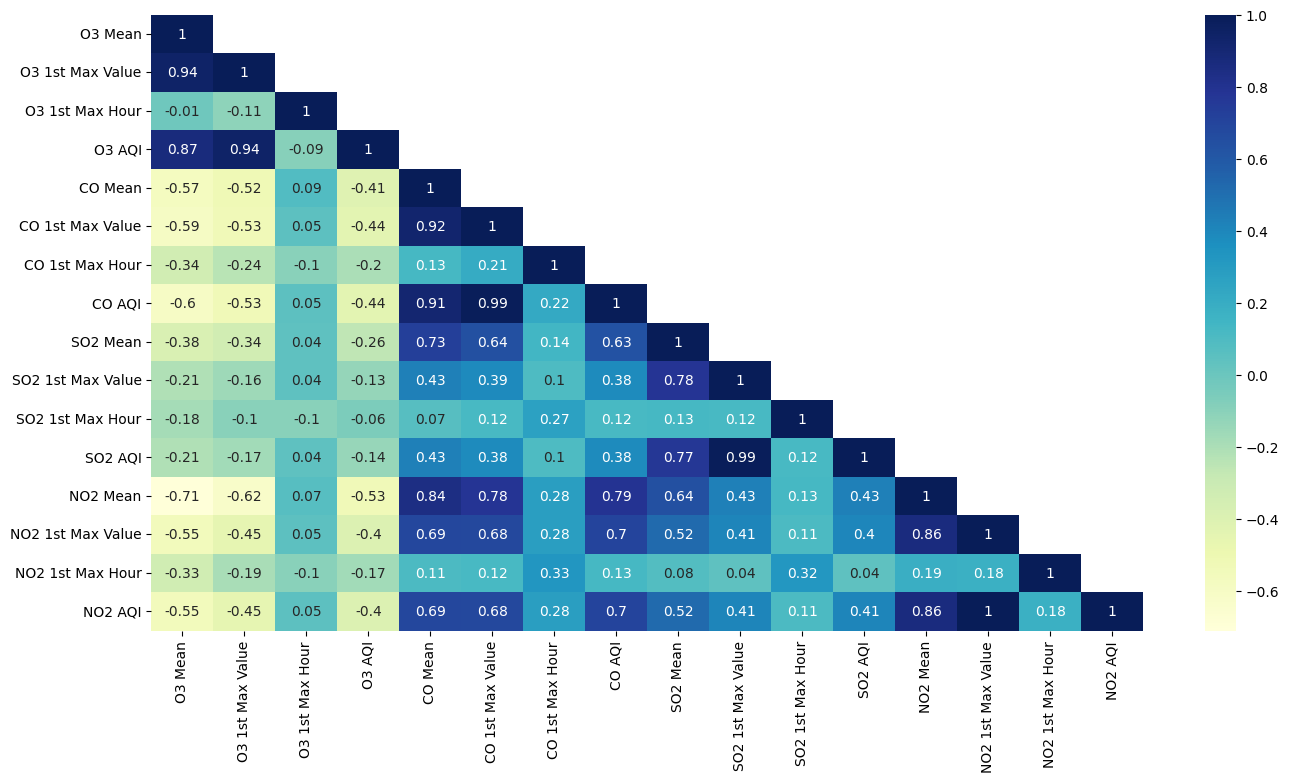

In [47]:
plt.figure(figsize = (16, 8))
primary_correlation_matrix = primary_address_analysis.drop(columns = ['Date']).corr(numeric_only = True).round(2)
sns.heatmap(primary_correlation_matrix, annot = True, cmap = 'YlGnBu', mask = np.triu(primary_correlation_matrix, 1))
plt.show()

### IMP Observations
1. O3 mean shows high positive correlation with O3 AQI.
2. CO mean shows high positive correlation with CO AQI, NO2 mean, NO2 AQI, & SO2 mean.
3. NO2 mean shows high positive correlation with NO2 AQI.
4. NO2 AQI shows perfect correlation with the first max value of the NO2.
5. First max value of SO2 shows extremely strong correlation with SO2 AQI.

> Point 2 implies presence of CO in the atmosphere is strongly related with the presence of the NO2 & SO2.

# RNN Model

In [48]:
us_pollution_dataset.set_index('Date', inplace = True)

In [49]:
o3_mean = us_pollution_dataset['O3 Mean']

In [50]:
data = o3_mean.values.reshape(-1, 1)

In [51]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [52]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

sequence_length = 10

X, y = create_sequences(data_scaled, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 32, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 16))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(X_train, y_train, epochs = 8, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/8
16636/16636 [==============================] - 161s 9ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 2/8
16636/16636 [==============================] - 153s 9ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 3/8
16636/16636 [==============================] - 147s 9ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 4/8
16636/16636 [==============================] - 146s 9ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 5/8
16636/16636 [==============================] - 147s 9ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 6/8
16636/16636 [==============================] - 153s 9ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 7/8
16636/16636 [==============================] - 146s 9ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 8/8
16636/16636 [==============================] - 146s 9ms/step - loss: 0.0051 - val_loss: 0.0049


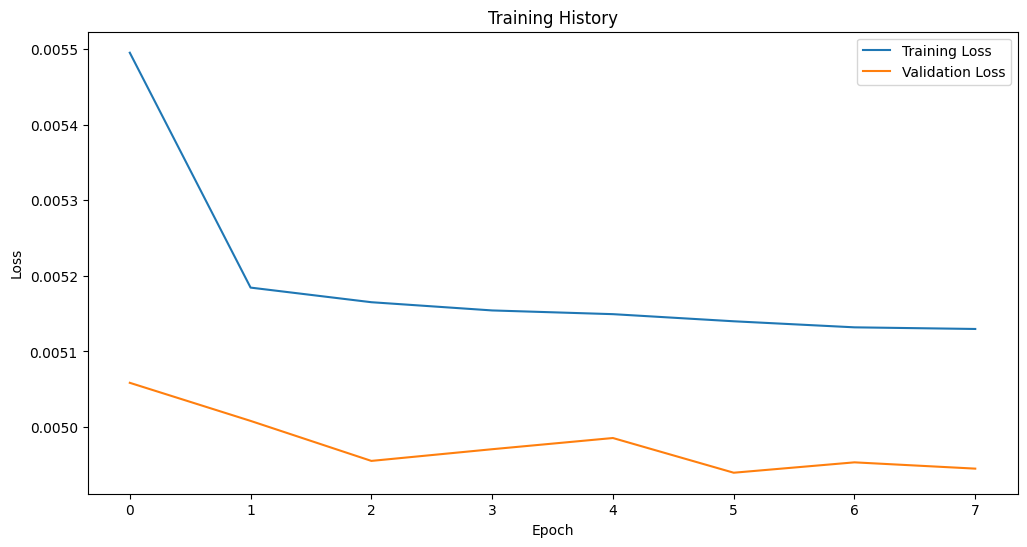

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()